# project topic 1 Oct 2025

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import xgboost as xgb
import lightgbm as lgb

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/main/ProjectAssignmentData/Dataset-PT.csv'

df = pd.read_csv(url, header=1)
columns_to_drop = ['Basic information', 'Categorical varibles', 'Categorical variables (dummy variables)']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

new_columns = []
for col in df.columns:
    if 'Unnamed' not in col:
        new_columns.append(col)
    else:
        new_columns.append(col)

df.columns = new_columns

print(f"数据形状 Shape: {df.shape}")
print(f"数据大小 Size: {df.shape[0]:,} 行 rows × {df.shape[1]} 列 columns")

print("\n前5行数据 First 5 rows:")
print(df.head())

print("\n数据列名 Column names:")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")


数据形状 Shape: (545103, 31)
数据大小 Size: 545,103 行 rows × 31 列 columns

前5行数据 First 5 rows:
   Calendar_date  route_id  bus_id  stop_sequence  arrival_delay  dwell_time  \
0       20220108         4   41344              1            151           0   
1       20220108         4   41344              2            185          24   
2       20220108         4   41344              3            186           0   
3       20220108         4   41344              4            202          12   
4       20220108         4   41344              5            242          21   

   travel_time_for_previous_section  scheduled_travel_time  \
0                                 0                    120   
1                               171                     45   
2                                55                     41   
3                                42                     94   
4                                98                     86   

   upstream_stop_delay  origin_delay  previous_bus_delay  \

In [3]:
correct_columns = [
    # 基本信息 Basic information
    'Calendar_date',
    'route_id',
    'bus_id',
    'stop_sequence',

    # 目标变量 Target variable
    'arrival_delay',

    # 运营数据 Operational data
    'dwell_time',
    'travel_time_for_previous_section',
    'scheduled_travel_time',
    'upstream_stop_delay',
    'origin_delay',
    'previous_bus_delay',
    'previous_trip_travel_time',
    'traffic_condition',
    'recurrent_delay',

    # 分类变量原始值 Original categorical variables
    'weather',
    'temperature',
    'day_of_week',
    'time_of_day',

    # 分类变量哑变量 Dummy variables
    'factor(weather)Light_Rain',
    'factor(weather)Light_Snow',
    'factor(weather)Normal',
    'factor(weather)Rain',
    'factor(weather)Snow',
    'factor(temperature)Cold',
    'factor(temperature)Extra_cold',
    'factor(temperature)Normal',
    'factor(day_of_week)weekday',
    'factor(day_of_week)weekend',
    'factor(time_of_day)Afternoon_peak',
    'factor(time_of_day)Morning_peak',
    'factor(time_of_day)Off-peak'
]

# 检查列数是否匹配 Check if column count matches
if len(df.columns) == len(correct_columns):
    df.columns = correct_columns
    print("Column names set successfully!")
else:
    print(f"Error")

Column names set successfully!


In [4]:
print("正在转换数据类型... Converting data types...")

df['Calendar_date'] = pd.to_datetime(df['Calendar_date'], format='%Y%m%d')

# 转换数值列 Convert numerical columns
numerical_cols = [
    'route_id', 'bus_id', 'stop_sequence', 'arrival_delay', 'dwell_time',
    'travel_time_for_previous_section', 'scheduled_travel_time',
    'upstream_stop_delay', 'origin_delay', 'previous_bus_delay',
    'previous_trip_travel_time', 'traffic_condition', 'recurrent_delay'
]

for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 转换哑变量为整数 Convert dummy variables to integer
dummy_cols = [col for col in df.columns if 'factor(' in col]
for col in dummy_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# 最终数据验证 Final data validation

print("最终数据验证 Final Data Validation")

print(f"数据形状 Shape: {df.shape}")
print(f"数据大小 Size: {df.shape[0]:,} 行 rows × {df.shape[1]} 列 columns")

print("\n数据类型 Data types:")
print(df.dtypes)



正在转换数据类型... Converting data types...
最终数据验证 Final Data Validation
数据形状 Shape: (545103, 31)
数据大小 Size: 545,103 行 rows × 31 列 columns

数据类型 Data types:
Calendar_date                        datetime64[ns]
route_id                                      int64
bus_id                                        int64
stop_sequence                                 int64
arrival_delay                                 int64
dwell_time                                    int64
travel_time_for_previous_section              int64
scheduled_travel_time                         int64
upstream_stop_delay                           int64
origin_delay                                  int64
previous_bus_delay                            int64
previous_trip_travel_time                     int64
traffic_condition                           float64
recurrent_delay                             float64
weather                                      object
temperature                                  object
day_of_week       

# 描述性分析
## 数据预处理

In [5]:
df_analysis = df.copy()

# 提取时间特征 Extract temporal features
df_analysis['year'] = df_analysis['Calendar_date'].dt.year
df_analysis['month'] = df_analysis['Calendar_date'].dt.month
df_analysis['day'] = df_analysis['Calendar_date'].dt.day
df_analysis['weekday'] = df_analysis['Calendar_date'].dt.weekday  # 0=Monday, 6=Sunday
df_analysis['week'] = df_analysis['Calendar_date'].dt.isocalendar().week
df_analysis['day_of_year'] = df_analysis['Calendar_date'].dt.dayofyear

weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df_analysis['weekday_name'] = df_analysis['weekday'].map(weekday_map)

month_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April',
             5: 'May', 6: 'June', 7: 'July', 8: 'August',
             9: 'September', 10: 'October', 11: 'November', 12: 'December'}
df_analysis['month_name'] = df_analysis['month'].map(month_map)

df_analysis['is_weekend'] = df_analysis['factor(day_of_week)weekend']
df_analysis['day_type'] = df_analysis['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})

## 基本统计

In [6]:
# 选择关键数值变量 Select key numerical variables
key_vars = ['arrival_delay', 'dwell_time', 'travel_time_for_previous_section',
            'scheduled_travel_time', 'upstream_stop_delay', 'origin_delay',
            'previous_bus_delay', 'recurrent_delay', 'traffic_condition']

desc_stats = df_analysis[key_vars].describe().T
desc_stats['median'] = df_analysis[key_vars].median()
desc_stats['skewness'] = df_analysis[key_vars].skew()
desc_stats['kurtosis'] = df_analysis[key_vars].kurtosis()

desc_stats = desc_stats[['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis']]


In [7]:
print("到站延误 Arrival Delay")

arrival_delay = df_analysis['arrival_delay']

delay_stats = {
    '样本总数 Total samples': len(arrival_delay),
    '平均延误 Mean delay (seconds)': arrival_delay.mean(),
    '中位数延误 Median delay (seconds)': arrival_delay.median(),
    '标准差 Std deviation (seconds)': arrival_delay.std(),
    '最小值 Min (seconds)': arrival_delay.min(),
    '最大值 Max (seconds)': arrival_delay.max(),
}

for key, value in delay_stats.items():
    print(f"{key}: {value:.2f}")

print("\n")

df_analysis['delay_category'] = pd.cut(
    df_analysis['arrival_delay'],
    bins=[-np.inf, -60, 0, 60, 180, 300, np.inf],
    labels=['提前>1分钟 Early>1min', '提前<1分钟 Early<1min', '准点±1分钟 On-time±1min',
            '延误1-3分钟 Delay 1-3min', '延误3-5分钟 Delay 3-5min', '延误>5分钟 Delay>5min']
)

delay_category_stats = df_analysis['delay_category'].value_counts().sort_index()
delay_category_pct = (delay_category_stats / len(df_analysis) * 100).round(2)

delay_summary = pd.DataFrame({
    '数量 Count': delay_category_stats,
    '比例% Percentage': delay_category_pct
})
print(delay_summary)
print("\n"+"关键性能指标 Key Performance Indicators (KPIs)")
kpis = {
    '准点率 On-time rate (±60s)': (arrival_delay.abs() <= 60).mean() * 100,
    '准点率 On-time rate (±120s)': (arrival_delay.abs() <= 120).mean() * 100,
    '严重延误率 Severe delay rate (>300s)': (arrival_delay > 300).mean() * 100,
    '提前到达率 Early arrival rate (<-60s)': (arrival_delay < -60).mean() * 100,
    '平均绝对延误 Mean absolute delay (seconds)': arrival_delay.abs().mean(),
}
for key, value in kpis.items():
    print(f"{key}: {value:.2f}%") if '%' in key else print(f"{key}: {value:.2f}")


到站延误 Arrival Delay
样本总数 Total samples: 545103.00
平均延误 Mean delay (seconds): 134.97
中位数延误 Median delay (seconds): 88.00
标准差 Std deviation (seconds): 193.90
最小值 Min (seconds): -3493.00
最大值 Max (seconds): 2257.00


                      数量 Count  比例% Percentage
delay_category                                
提前>1分钟 Early>1min        36016            6.61
提前<1分钟 Early<1min        80222           14.72
准点±1分钟 On-time±1min     110669           20.30
延误1-3分钟 Delay 1-3min    157829           28.95
延误3-5分钟 Delay 3-5min     78116           14.33
延误>5分钟 Delay>5min        82251           15.09

关键性能指标 Key Performance Indicators (KPIs)
准点率 On-time rate (±60s): 35.16
准点率 On-time rate (±120s): 56.76
严重延误率 Severe delay rate (>300s): 15.09
提前到达率 Early arrival rate (<-60s): 6.47
平均绝对延误 Mean absolute delay (seconds): 157.74


## 时间维度分析


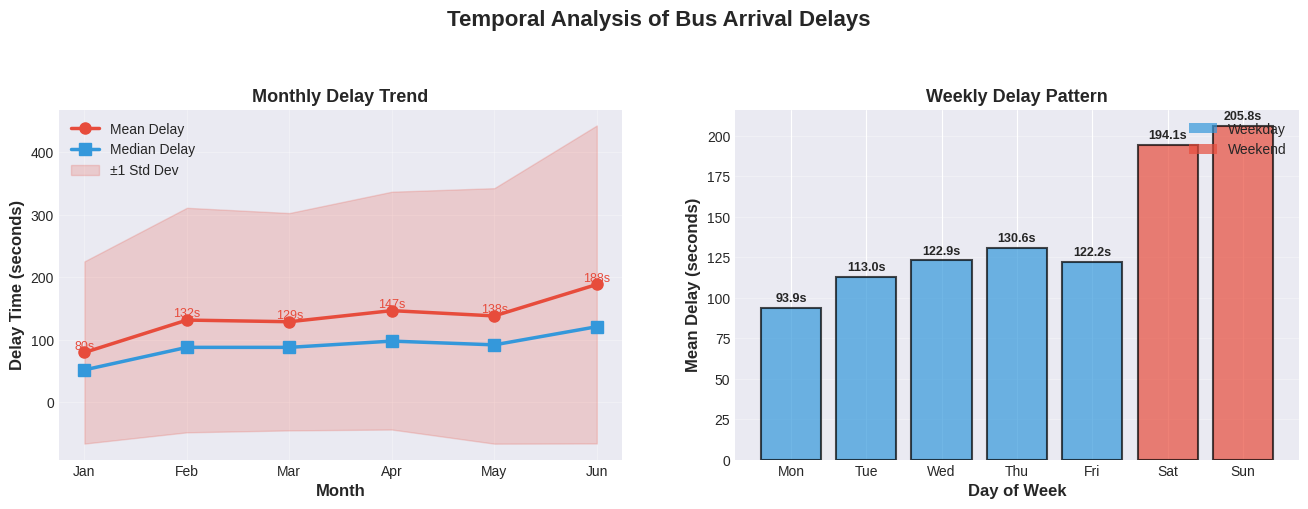

In [ ]:
# 创建时间分析图表 Create temporal analysis plots (English only)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Temporal Analysis of Bus Arrival Delays', fontsize=16, fontweight='bold')

# 1. Monthly Trend
monthly_delay = df_analysis.groupby('month')['arrival_delay'].agg(['mean', 'median', 'std', 'count'])
ax1 = axes[0, 0]
x = monthly_delay.index
ax1.plot(x, monthly_delay['mean'], marker='o', linewidth=2.5, markersize=8,
         label='Mean Delay', color='#e74c3c')
ax1.plot(x, monthly_delay['median'], marker='s', linewidth=2.5, markersize=8,
         label='Median Delay', color='#3498db')
ax1.fill_between(x,
                  monthly_delay['mean'] - monthly_delay['std'],
                  monthly_delay['mean'] + monthly_delay['std'],
                  alpha=0.2, color='#e74c3c', label='±1 Std Dev')
ax1.set_xlabel('Month', fontsize=12, fontweight='bold')
ax1.set_ylabel('Delay Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Monthly Delay Trend', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, 7))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

# Add value labels
for i, (mean_val, median_val) in enumerate(zip(monthly_delay['mean'], monthly_delay['median']), 1):
    ax1.text(i, mean_val + 5, f'{mean_val:.0f}s', ha='center', fontsize=9, color='#e74c3c')

# 2. Weekly Pattern
weekday_delay = df_analysis.groupby('weekday')['arrival_delay'].agg(['mean', 'std', 'count'])
ax2 = axes[0, 1]
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
colors = ['#3498db'] * 5 + ['#e74c3c'] * 2  # Blue for weekdays, red for weekends
bars = ax2.bar(range(7), weekday_delay['mean'].values, color=colors, alpha=0.7,
               edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean Delay (seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Weekly Delay Pattern', fontsize=13, fontweight='bold')
ax2.set_xticks(range(7))
ax2.set_xticklabels(weekday_names, fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{height:.1f}s', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', alpha=0.7, label='Weekday'),
                   Patch(facecolor='#e74c3c', alpha=0.7, label='Weekend')]
ax2.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.delaxes(axes[1, 0])
plt.delaxes(axes[1, 1])

In [ ]:
# Print detailed temporal statistics
print("\n1. MONTHLY TREND ANALYSIS")
print("-" * 80)
print(f"Highest delay month: Month {monthly_delay['mean'].idxmax()} ({monthly_delay['mean'].max():.2f}s)")
print(f"Lowest delay month: Month {monthly_delay['mean'].idxmin()} ({monthly_delay['mean'].min():.2f}s)")
print(f"Monthly variation (std): {monthly_delay['mean'].std():.2f}s")
print(f"Delay increase from Jan to Jun: {monthly_delay['mean'].iloc[-1] - monthly_delay['mean'].iloc[0]:.2f}s")

print("\n2. WEEKLY PATTERN ANALYSIS")
print("-" * 80)
weekday_avg = weekday_delay['mean'][:5].mean()
weekend_avg = weekday_delay['mean'][5:].mean()
print(f"Weekday average delay: {weekday_avg:.2f}s")
print(f"Weekend average delay: {weekend_avg:.2f}s")
print(f"Difference (Weekend - Weekday): {weekend_avg - weekday_avg:.2f}s ({((weekend_avg - weekday_avg) / weekday_avg * 100):.1f}%)")
print(f"Highest delay day: {weekday_names[weekday_delay['mean'].idxmax()]} ({weekday_delay['mean'].max():.2f}s)")
print(f"Lowest delay day: {weekday_names[weekday_delay['mean'].idxmin()]} ({weekday_delay['mean'].min():.2f}s)")



1. MONTHLY TREND ANALYSIS
--------------------------------------------------------------------------------
Highest delay month: Month 6 (188.45s)
Lowest delay month: Month 1 (79.80s)
Monthly variation (std): 34.92s
Delay increase from Jan to Jun: 108.66s

2. WEEKLY PATTERN ANALYSIS
--------------------------------------------------------------------------------
Weekday average delay: 116.53s
Weekend average delay: 199.98s
Difference (Weekend - Weekday): 83.46s (71.6%)
Highest delay day: Sun (205.85s)
Lowest delay day: Mon (93.87s)


## 空间维度分析


In [ ]:
# 按站点统计延误 Delay statistics by stop
stop_delay = df_analysis.groupby('stop_sequence')['arrival_delay'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

stop_delay.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max']

# 添加额外统计 Add additional statistics
stop_delay['CV'] = (stop_delay['Std'] / stop_delay['Mean']).round(2)  # Coefficient of Variation
stop_delay['Range'] = stop_delay['Max'] - stop_delay['Min']

print("\nStop-wise Delay Statistics (All 28 stops):")
print(stop_delay)

# 识别问题站点 Identify problematic stops
print("PROBLEMATIC STOPS IDENTIFICATION")

threshold_mean = stop_delay['Mean'].mean() + stop_delay['Mean'].std()
threshold_std = stop_delay['Std'].mean() + stop_delay['Std'].std()

problem_stops_high_delay = stop_delay[stop_delay['Mean'] > threshold_mean].index.tolist()
problem_stops_high_var = stop_delay[stop_delay['Std'] > threshold_std].index.tolist()

print(f"\nStops with HIGH AVERAGE DELAY (>{threshold_mean:.1f}s):")
print(f"Stop sequences: {problem_stops_high_delay}")

print(f"\nStops with HIGH VARIABILITY (std>{threshold_std:.1f}s):")
print(f"Stop sequences: {problem_stops_high_var}")

# 最好和最差的站点 Best and worst stops
print("TOP 5 BEST PERFORMING STOPS (Lowest Mean Delay)")
print(stop_delay.nsmallest(5, 'Mean')[['Mean', 'Median', 'Std']])

print("TOP 5 WORST PERFORMING STOPS (Highest Mean Delay)")
print(stop_delay.nlargest(5, 'Mean')[['Mean', 'Median', 'Std']])



Stop-wise Delay Statistics (All 28 stops):
               Count   Mean  Median    Std   Min   Max   CV  Range
stop_sequence                                                     
1              20189  63.96   22.00 145.57 -3136  1916 2.28   5052
2              20189 100.14   60.00 150.18 -3114  1894 1.50   5008
3              20189  92.83   54.00 152.24 -3152  1895 1.64   5047
4              20189  65.27   29.00 157.16 -3159  1887 2.41   5046
5              20189 107.41   65.00 156.26 -3175  2079 1.45   5254
6              20189 138.43   97.00 160.27 -3148  2094 1.16   5242
7              20189 128.25   88.00 164.84 -3175  2050 1.29   5225
8              20189 106.23   68.00 171.64 -3229  2067 1.62   5296
9              20189 136.35   93.00 171.47 -3211  2094 1.26   5305
10             20189 161.18  119.00 176.47 -3222  2071 1.09   5293
11             20189 130.10   88.00 179.90 -3263  2068 1.38   5331
12             20189  89.43   49.00 182.07 -3355  1989 2.04   5344
13             201

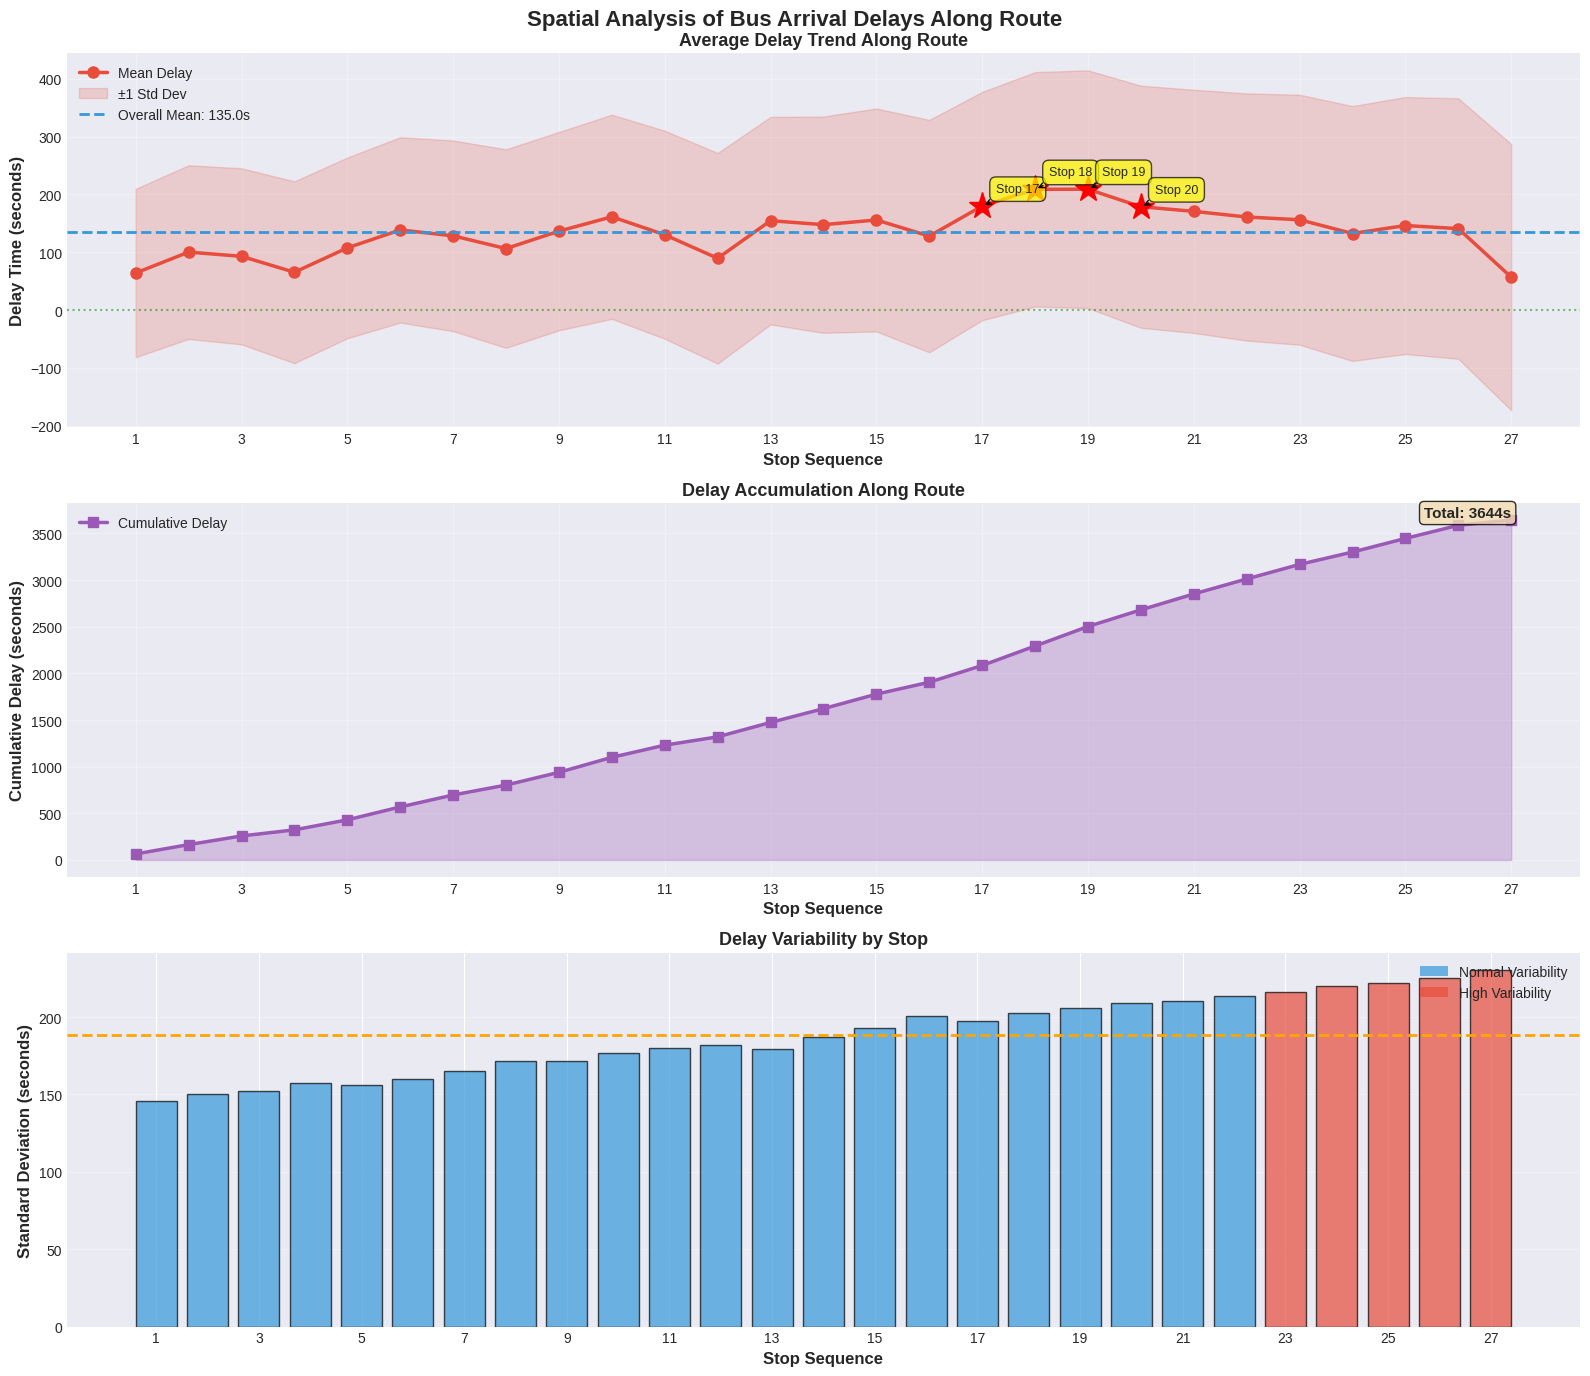

In [ ]:
# 创建空间分析图表 Create spatial analysis plots
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
fig.suptitle('Spatial Analysis of Bus Arrival Delays Along Route',
             fontsize=16, fontweight='bold')

# 1. Stop-wise Average Delay Trend
ax1 = axes[0]
stops = stop_delay.index
ax1.plot(stops, stop_delay['Mean'], marker='o', linewidth=2.5,
         markersize=8, color='#e74c3c', label='Mean Delay')
ax1.fill_between(stops,
                  stop_delay['Mean'] - stop_delay['Std'],
                  stop_delay['Mean'] + stop_delay['Std'],
                  alpha=0.2, color='#e74c3c', label='±1 Std Dev')
ax1.axhline(y=stop_delay['Mean'].mean(), color='#3498db',
            linestyle='--', linewidth=2,
            label=f'Overall Mean: {stop_delay["Mean"].mean():.1f}s')
ax1.axhline(y=0, color='green', linestyle=':', linewidth=1.5, alpha=0.5)

ax1.set_xlabel('Stop Sequence', fontsize=12, fontweight='bold')
ax1.set_ylabel('Delay Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Average Delay Trend Along Route', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(stops[::2])  # Show every other stop

# Mark problematic stops
for stop in problem_stops_high_delay:
    ax1.plot(stop, stop_delay.loc[stop, 'Mean'], 'r*', markersize=20)
    ax1.annotate(f'Stop {stop}',
                 xy=(stop, stop_delay.loc[stop, 'Mean']),
                 xytext=(10, 10), textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
                 fontsize=9)

# 2. Delay Accumulation Effect
ax2 = axes[1]
cumulative_delay = stop_delay['Mean'].cumsum()
ax2.plot(stops, cumulative_delay, marker='s', linewidth=2.5,
         markersize=7, color='#9b59b6', label='Cumulative Delay')
ax2.fill_between(stops, 0, cumulative_delay, alpha=0.3, color='#9b59b6')

ax2.set_xlabel('Stop Sequence', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Delay (seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Delay Accumulation Along Route', fontsize=13, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(stops[::2])

# Add annotation for total accumulation
total_accum = cumulative_delay.iloc[-1]
ax2.text(stops[-1], total_accum, f'Total: {total_accum:.0f}s',
         ha='right', va='bottom', fontsize=11, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 3. Delay Variability by Stop
ax3 = axes[2]
colors_var = ['#e74c3c' if std > threshold_std else '#3498db'
              for std in stop_delay['Std']]
bars = ax3.bar(stops, stop_delay['Std'], color=colors_var, alpha=0.7,
               edgecolor='black', linewidth=1)
ax3.axhline(y=stop_delay['Std'].mean(), color='orange',
            linestyle='--', linewidth=2,
            label=f'Mean Std: {stop_delay["Std"].mean():.1f}s')

ax3.set_xlabel('Stop Sequence', fontsize=12, fontweight='bold')
ax3.set_ylabel('Standard Deviation (seconds)', fontsize=12, fontweight='bold')
ax3.set_title('Delay Variability by Stop', fontsize=13, fontweight='bold')
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_xticks(stops[::2])

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', alpha=0.7, label='Normal Variability'),
                   Patch(facecolor='#e74c3c', alpha=0.7, label='High Variability')]
ax3.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()



## 天气和其他因素分析

In [ ]:
# 1. Weather Impact Analysis
print("\n1. WEATHER CONDITION IMPACT")

weather_delay = df_analysis.groupby('weather')['arrival_delay'].agg([
    'count', 'mean', 'median', 'std'
]).round(2)
weather_delay.columns = ['Count', 'Mean', 'Median', 'Std']
weather_delay['Percentage'] = (weather_delay['Count'] / len(df_analysis) * 100).round(2)
weather_delay = weather_delay.sort_values('Mean', ascending=False)
print(weather_delay)

# 2. Temperature Impact Analysis
print("\n2. TEMPERATURE IMPACT")

temp_delay = df_analysis.groupby('temperature')['arrival_delay'].agg([
    'count', 'mean', 'median', 'std'
]).round(2)
temp_delay.columns = ['Count', 'Mean', 'Median', 'Std']
temp_delay['Percentage'] = (temp_delay['Count'] / len(df_analysis) * 100).round(2)
temp_delay = temp_delay.sort_values('Mean', ascending=False)
print(temp_delay)

# 3. Traffic Condition Analysis
print("\n3. TRAFFIC CONDITION CORRELATION")

traffic_corr = df_analysis[['arrival_delay', 'traffic_condition']].corr()
print(f"Correlation between arrival_delay and traffic_condition: {traffic_corr.iloc[0, 1]:.4f}")

# Traffic condition statistics
traffic_stats = df_analysis['traffic_condition'].describe()
print(f"\nTraffic Condition Statistics:")
print(f"Mean: {traffic_stats['mean']:.2f}s")
print(f"Median: {traffic_stats['50%']:.2f}s")
print(f"Std: {traffic_stats['std']:.2f}s")
print(f"Min: {traffic_stats['min']:.2f}s")
print(f"Max: {traffic_stats['max']:.2f}s")



1. WEATHER CONDITION IMPACT
             Count   Mean  Median    Std  Percentage
weather                                             
Rain          3375 161.58  117.00 187.17        0.62
Normal      514971 136.03   89.00 195.70       94.47
Snow          3699 131.27   82.00 174.48        0.68
Light Snow    9720 116.78   83.00 144.64        1.78
Light Rain   13338 101.52   66.00 154.03        2.45

2. TEMPERATURE IMPACT
              Count   Mean  Median    Std  Percentage
temperature                                          
Normal       473877 136.66   88.00 196.54       86.93
Cold          61452 127.58   88.00 179.40       11.27
Extra cold     9774  99.67   71.00 140.92        1.79

3. TRAFFIC CONDITION CORRELATION
Correlation between arrival_delay and traffic_condition: -0.0431

Traffic Condition Statistics:
Mean: 73.15s
Median: 65.00s
Std: 32.32s
Min: 18.33s
Max: 732.67s


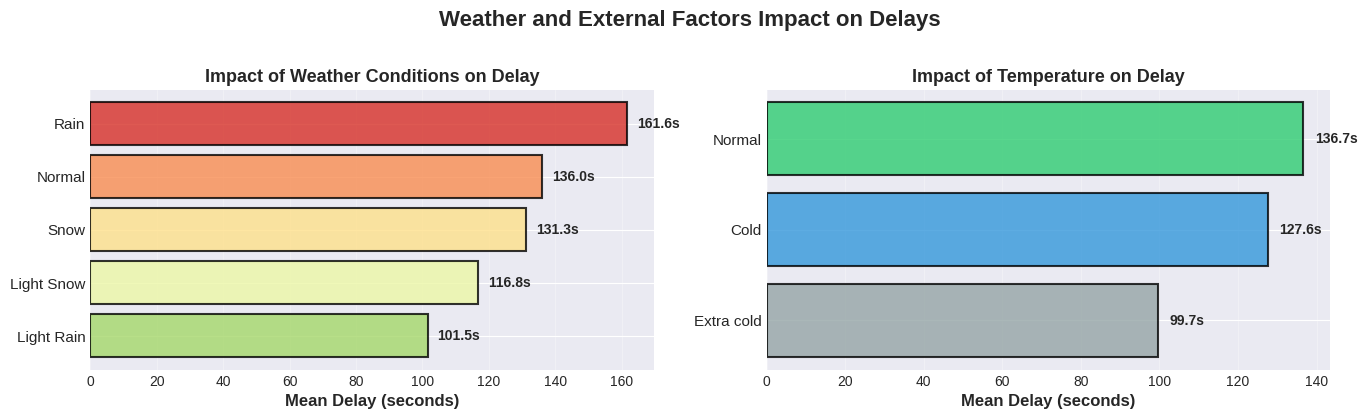

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle('Weather and External Factors Impact on Delays',
             fontsize=16, fontweight='bold')

# 1. Weather Condition Impact
ax1 = axes[0, 0]
weather_sorted = weather_delay.sort_values('Mean', ascending=True)
colors_weather = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(weather_sorted)))
bars = ax1.barh(range(len(weather_sorted)), weather_sorted['Mean'],
                color=colors_weather, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_yticks(range(len(weather_sorted)))
ax1.set_yticklabels(weather_sorted.index, fontsize=11)
ax1.set_xlabel('Mean Delay (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Impact of Weather Conditions on Delay', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + 3, bar.get_y() + bar.get_height()/2.,
             f'{width:.1f}s', ha='left', va='center', fontsize=10, fontweight='bold')

# 2. Temperature Impact
ax2 = axes[0, 1]
temp_sorted = temp_delay.sort_values('Mean', ascending=True)
colors_temp = ['#3498db', '#f39c12', '#e74c3c']  # Cold, Normal, Extra_cold
temp_color_map = {'Cold': '#3498db', 'Normal': '#2ecc71', 'Extra_cold': '#e74c3c'}
colors_temp_actual = [temp_color_map.get(t, '#95a5a6') for t in temp_sorted.index]

bars = ax2.barh(range(len(temp_sorted)), temp_sorted['Mean'],
                color=colors_temp_actual, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(len(temp_sorted)))
ax2.set_yticklabels(temp_sorted.index, fontsize=11)
ax2.set_xlabel('Mean Delay (seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Impact of Temperature on Delay', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 3, bar.get_y() + bar.get_height()/2.,
             f'{width:.1f}s', ha='left', va='center', fontsize=10, fontweight='bold')

plt.delaxes(axes[1, 0])
plt.delaxes(axes[1, 1])


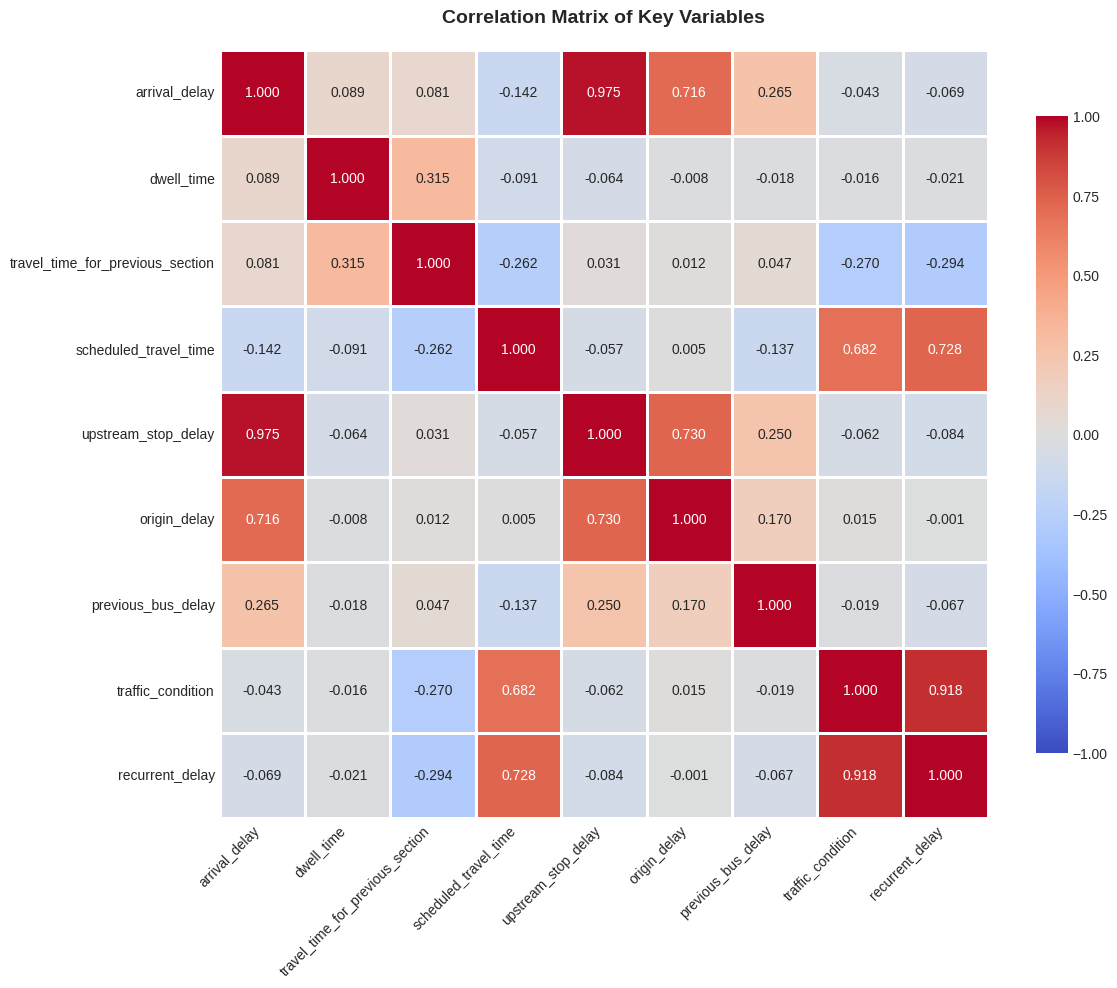


Top Correlations with Arrival Delay:
upstream_stop_delay                     :  0.9750
origin_delay                            :  0.7163
previous_bus_delay                      :  0.2654
dwell_time                              :  0.0894
travel_time_for_previous_section        :  0.0811
traffic_condition                       : -0.0431
recurrent_delay                         : -0.0691
scheduled_travel_time                   : -0.1422
Strong Correlations (|r| > 0.5):
upstream_stop_delay                     :  0.9750
origin_delay                            :  0.7163


In [ ]:
# 相关性分析 Correlation Analysis
# Select key variables for correlation analysis
corr_vars = [
    'arrival_delay',
    'dwell_time',
    'travel_time_for_previous_section',
    'scheduled_travel_time',
    'upstream_stop_delay',
    'origin_delay',
    'previous_bus_delay',
    'traffic_condition',
    'recurrent_delay'
]

# Calculate correlation matrix
corr_matrix = df_analysis[corr_vars].corr()

# Create correlation heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)

ax.set_title('Correlation Matrix of Key Variables', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Print top correlations with arrival_delay
print("\nTop Correlations with Arrival Delay:")

delay_corr = corr_matrix['arrival_delay'].drop('arrival_delay').sort_values(ascending=False)
for var, corr_val in delay_corr.items():
    print(f"{var:40s}: {corr_val:7.4f}")

# Identify strong correlations

print("Strong Correlations (|r| > 0.5):")

strong_corr = delay_corr[abs(delay_corr) > 0.5]
for var, corr_val in strong_corr.items():
    print(f"{var:40s}: {corr_val:7.4f}")


# 特征选择与数据分割、标准化

In [9]:
print("1. EXISTING ITS - Limited Real-time Features")

existing_its_numerical = [
    'dwell_time',
    'scheduled_travel_time',
    'origin_delay',
    'traffic_condition',
    'recurrent_delay'
]

existing_its_dummy = [
    'factor(weather)Light_Rain',
    'factor(weather)Light_Snow',
    'factor(weather)Normal',
    'factor(weather)Rain',
    'factor(weather)Snow',
    'factor(temperature)Cold',
    'factor(temperature)Extra_cold',
    'factor(temperature)Normal',
    'factor(day_of_week)weekday',
    'factor(day_of_week)weekend',
    'factor(time_of_day)Afternoon_peak',
    'factor(time_of_day)Morning_peak',
    'factor(time_of_day)Off-peak'
]

existing_its_features = existing_its_numerical + existing_its_dummy

print(f"\nExisting ITS Features: {len(existing_its_features)} total")
print(f"  - Numerical features: {len(existing_its_numerical)}")
print(f"  - Dummy features: {len(existing_its_dummy)}")

print("\nNumerical Features (Existing ITS):")
for i, feat in enumerate(existing_its_numerical, 1):
    print(f"  {i}. {feat}")


print("2. ADVANCED ITS - Full Real-time Features")

advanced_its_additional = [
    'upstream_stop_delay',
    'previous_bus_delay',
    'previous_trip_travel_time',
    'travel_time_for_previous_section'
]

advanced_its_numerical = existing_its_numerical + advanced_its_additional

advanced_its_features = advanced_its_numerical + existing_its_dummy

print(f"\nAdvanced ITS Features: {len(advanced_its_features)} total")
print(f"  - Numerical features: {len(advanced_its_numerical)}")
print(f"  - Dummy features: {len(existing_its_dummy)}")

print("\nAdditional Features in Advanced ITS:")
for i, feat in enumerate(advanced_its_additional, 1):
    print(f"  {i}. {feat}")

print("\nAll Numerical Features (Advanced ITS):")
for i, feat in enumerate(advanced_its_numerical, 1):
    print(f"  {i}. {feat}")

print("COMPARISON SUMMARY")
print(f"Existing ITS:  {len(existing_its_features)} features")
print(f"Advanced ITS:  {len(advanced_its_features)} features")
print(f"Difference:    +{len(advanced_its_features) - len(existing_its_features)} features")


1. EXISTING ITS - Limited Real-time Features

Existing ITS Features: 18 total
  - Numerical features: 5
  - Dummy features: 13

Numerical Features (Existing ITS):
  1. dwell_time
  2. scheduled_travel_time
  3. origin_delay
  4. traffic_condition
  5. recurrent_delay
2. ADVANCED ITS - Full Real-time Features

Advanced ITS Features: 22 total
  - Numerical features: 9
  - Dummy features: 13

Additional Features in Advanced ITS:
  1. upstream_stop_delay
  2. previous_bus_delay
  3. previous_trip_travel_time
  4. travel_time_for_previous_section

All Numerical Features (Advanced ITS):
  1. dwell_time
  2. scheduled_travel_time
  3. origin_delay
  4. traffic_condition
  5. recurrent_delay
  6. upstream_stop_delay
  7. previous_bus_delay
  8. previous_trip_travel_time
  9. travel_time_for_previous_section
COMPARISON SUMMARY
Existing ITS:  18 features
Advanced ITS:  22 features
Difference:    +4 features


## 准备数据集

In [10]:
import time

# EXISTING ITS Dataset
print("\n1. Existing ITS Dataset")
target_col = ['arrival_delay']
X_existing = df_analysis[existing_its_features].copy()
# y_existing = df_analysis[target_col].copy()
y_existing = df_analysis[target_col].values.ravel()

print(f"Feature matrix shape: {X_existing.shape}")
print(f"Target variable shape: {y_existing.shape}")

# Train-test split for Existing ITS
X_train_existing, X_test_existing, y_train_existing, y_test_existing = train_test_split(
    X_existing, y_existing, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)

print(f"Training set: {X_train_existing.shape}")
print(f"Test set: {X_test_existing.shape}")

# Standardize Existing ITS features
scaler_existing = StandardScaler()
X_train_existing_scaled = X_train_existing.copy()
X_train_existing_scaled[existing_its_numerical] = scaler_existing.fit_transform(
    X_train_existing[existing_its_numerical]
)

X_test_existing_scaled = X_test_existing.copy()
X_test_existing_scaled[existing_its_numerical] = scaler_existing.transform(
    X_test_existing[existing_its_numerical]
)


# ADVANCED ITS Dataset

print("\n2. Advanced ITS Dataset")

X_advanced = df_analysis[advanced_its_features].copy()
# y_advanced = df_analysis[target_col].copy()
y_advanced = df_analysis[target_col].values.ravel()

print(f"Feature matrix shape: {X_advanced.shape}")
print(f"Target variable shape: {y_advanced.shape}")

# Train-test split for Advanced ITS
X_train_advanced, X_test_advanced, y_train_advanced, y_test_advanced = train_test_split(
    X_advanced, y_advanced, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)

print(f"Training set: {X_train_advanced.shape}")
print(f"Test set: {X_test_advanced.shape}")

# Standardize Advanced ITS features
scaler_advanced = StandardScaler()
X_train_advanced_scaled = X_train_advanced.copy()
X_train_advanced_scaled[advanced_its_numerical] = scaler_advanced.fit_transform(
    X_train_advanced[advanced_its_numerical]
)

X_test_advanced_scaled = X_test_advanced.copy()
X_test_advanced_scaled[advanced_its_numerical] = scaler_advanced.transform(
    X_test_advanced[advanced_its_numerical]
)


print("\nExisting ITS:")
print(f"  Training samples: {len(X_train_existing):,}")
print(f"  Test samples: {len(X_test_existing):,}")
print(f"  Features: {X_train_existing.shape[1]}")

print("\nAdvanced ITS:")
print(f"  Training samples: {len(X_train_advanced):,}")
print(f"  Test samples: {len(X_test_advanced):,}")
print(f"  Features: {X_train_advanced.shape[1]}")




1. Existing ITS Dataset
Feature matrix shape: (545103, 18)
Target variable shape: (545103,)
Training set: (436082, 18)
Test set: (109021, 18)

2. Advanced ITS Dataset
Feature matrix shape: (545103, 22)
Target variable shape: (545103,)
Training set: (436082, 22)
Test set: (109021, 22)

Existing ITS:
  Training samples: 436,082
  Test samples: 109,021
  Features: 18

Advanced ITS:
  Training samples: 436,082
  Test samples: 109,021
  Features: 22


# 模型训练与评估

## Linear Regression

### ITS

In [15]:
print("EXISTING ITS - Linear Regression")

# 训练线性回归模型
start_time = time.time()

lr_model_existing = LinearRegression()
lr_model_existing.fit(X_train_existing_scaled, y_train_existing)

training_time = time.time() - start_time

# 预测
y_train_pred_lr_existing = lr_model_existing.predict(X_train_existing_scaled)
y_test_pred_lr_existing = lr_model_existing.predict(X_test_existing_scaled)

# 计算评估指标
print("PERFORMANCE METRICS - EXISTING ITS")

# Training set metrics
train_r2_lr_existing = r2_score(y_train_existing, y_train_pred_lr_existing)
train_mae_lr_existing = mean_absolute_error(y_train_existing, y_train_pred_lr_existing)
train_rmse_lr_existing = np.sqrt(mean_squared_error(y_train_existing, y_train_pred_lr_existing))
train_mape_lr_existing = np.mean(np.abs((y_train_existing - y_train_pred_lr_existing) / y_train_existing)) * 100

print("\nTraining Set Performance:")
print(f"  R² Score:  {train_r2_lr_existing:.4f}")
print(f"  MAE:       {train_mae_lr_existing:.2f} seconds")
print(f"  RMSE:      {train_rmse_lr_existing:.2f} seconds")


# Test set metrics
test_r2_lr_existing = r2_score(y_test_existing, y_test_pred_lr_existing)
test_mae_lr_existing = mean_absolute_error(y_test_existing, y_test_pred_lr_existing)
test_rmse_lr_existing = np.sqrt(mean_squared_error(y_test_existing, y_test_pred_lr_existing))
test_mape_lr_existing = np.mean(np.abs((y_test_existing - y_test_pred_lr_existing) / y_test_existing)) * 100

print("\nTest Set Performance:")
print(f"  R² Score:  {test_r2_lr_existing:.4f}")
print(f"  MAE:       {test_mae_lr_existing:.2f} seconds")
print(f"  RMSE:      {test_rmse_lr_existing:.2f} seconds")


# 特征重要性分析（线性回归系数）
print("Top 10 Most Important Features (by absolute coefficient):")
feature_importance_lr = pd.DataFrame({
    'Feature': existing_its_features,
    'Coefficient': lr_model_existing.coef_
})

feature_importance_lr['Abs_Coefficient'] = np.abs(feature_importance_lr['Coefficient'])
feature_importance_lr = feature_importance_lr.sort_values('Abs_Coefficient', ascending=False)

for idx, row in feature_importance_lr.head(10).iterrows():
    print(f"  {row['Feature']:40s} : {row['Coefficient']:8.4f}")


EXISTING ITS - Linear Regression
PERFORMANCE METRICS - EXISTING ITS

Training Set Performance:
  R² Score:  0.5547
  MAE:       95.03 seconds
  RMSE:      129.49 seconds

Test Set Performance:
  R² Score:  0.5514
  MAE:       95.45 seconds
  RMSE:      129.51 seconds
Top 10 Most Important Features (by absolute coefficient):
  origin_delay                             : 137.7413
  scheduled_travel_time                    : -32.5160
  factor(time_of_day)Afternoon_peak        : -19.6241
  dwell_time                               :  17.2285
  factor(weather)Light_Rain                : -15.4628
  traffic_condition                        :  14.6184
  factor(day_of_week)weekday               : -13.5662
  factor(day_of_week)weekend               :  13.5662
  factor(time_of_day)Off-peak              :  10.0561
  factor(time_of_day)Morning_peak          :   9.5679


### Ad ITS

In [16]:
start_time = time.time()

lr_model_advanced = LinearRegression()
lr_model_advanced.fit(X_train_advanced_scaled, y_train_advanced)


# 预测
y_train_pred_lr_advanced = lr_model_advanced.predict(X_train_advanced_scaled)
y_test_pred_lr_advanced = lr_model_advanced.predict(X_test_advanced_scaled)

print("PERFORMANCE METRICS - ADVANCED ITS")

# Training set metrics
train_r2_lr_advanced = r2_score(y_train_advanced, y_train_pred_lr_advanced)
train_mae_lr_advanced = mean_absolute_error(y_train_advanced, y_train_pred_lr_advanced)
train_rmse_lr_advanced = np.sqrt(mean_squared_error(y_train_advanced, y_train_pred_lr_advanced))
train_mape_lr_advanced = np.mean(np.abs((y_train_advanced - y_train_pred_lr_advanced) / y_train_advanced)) * 100

print("\nTraining Set Performance:")
print(f"  R² Score:  {train_r2_lr_advanced:.4f}")
print(f"  MAE:       {train_mae_lr_advanced:.2f} seconds")
print(f"  RMSE:      {train_rmse_lr_advanced:.2f} seconds")

# Test set metrics
test_r2_lr_advanced = r2_score(y_test_advanced, y_test_pred_lr_advanced)
test_mae_lr_advanced = mean_absolute_error(y_test_advanced, y_test_pred_lr_advanced)
test_rmse_lr_advanced = np.sqrt(mean_squared_error(y_test_advanced, y_test_pred_lr_advanced))
test_mape_lr_advanced = np.mean(np.abs((y_test_advanced - y_test_pred_lr_advanced) / y_test_advanced)) * 100

print("\nTest Set Performance:")
print(f"  R² Score:  {test_r2_lr_advanced:.4f}")
print(f"  MAE:       {test_mae_lr_advanced:.2f} seconds")
print(f"  RMSE:      {test_rmse_lr_advanced:.2f} seconds")

# 特征重要性分析

print("Top 10 Most Important Features (by absolute coefficient):")

feature_importance_lr_adv = pd.DataFrame({
    'Feature': advanced_its_features,
    'Coefficient': lr_model_advanced.coef_
})
feature_importance_lr_adv['Abs_Coefficient'] = np.abs(feature_importance_lr_adv['Coefficient'])
feature_importance_lr_adv = feature_importance_lr_adv.sort_values('Abs_Coefficient', ascending=False)

for idx, row in feature_importance_lr_adv.head(10).iterrows():
    print(f"  {row['Feature']:40s} : {row['Coefficient']:8.4f}")

# 对比两个系统

print("COMPARISON: EXISTING ITS vs ADVANCED ITS (Linear Regression)")
comparison_lr = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (seconds)', 'RMSE (seconds)'],
    'Existing ITS': [
        f"{test_r2_lr_existing:.4f}",
        f"{test_mae_lr_existing:.2f}",
        f"{test_rmse_lr_existing:.2f}"
    ],
    'Advanced ITS': [
        f"{test_r2_lr_advanced:.4f}",
        f"{test_mae_lr_advanced:.2f}",
        f"{test_rmse_lr_advanced:.2f}"
    ],
    'Improvement': [
        f"{((test_r2_lr_advanced - test_r2_lr_existing) / test_r2_lr_existing * 100):.2f}%",
        f"{((test_mae_lr_existing - test_mae_lr_advanced) / test_mae_lr_existing * 100):.2f}%",
        f"{((test_rmse_lr_existing - test_rmse_lr_advanced) / test_rmse_lr_existing * 100):.2f}%"

    ]
})

print("\n" + comparison_lr.to_string(index=False))



PERFORMANCE METRICS - ADVANCED ITS

Training Set Performance:
  R² Score:  0.9901
  MAE:       12.55 seconds
  RMSE:      19.30 seconds

Test Set Performance:
  R² Score:  0.9894
  MAE:       12.58 seconds
  RMSE:      19.93 seconds
Top 10 Most Important Features (by absolute coefficient):
  upstream_stop_delay                      : 191.4650
  scheduled_travel_time                    : -35.5131
  dwell_time                               :  26.5797
  recurrent_delay                          :  21.1830
  traffic_condition                        :   7.8245
  previous_trip_travel_time                :   1.1394
  previous_bus_delay                       :   0.8879
  travel_time_for_previous_section         :   0.6200
  origin_delay                             :  -0.5440
  factor(time_of_day)Morning_peak          :   0.4874
COMPARISON: EXISTING ITS vs ADVANCED ITS (Linear Regression)

        Metric Existing ITS Advanced ITS Improvement
      R² Score       0.5514       0.9894      79.42%
 

## RF

### ITS


In [11]:
from sklearn.ensemble import RandomForestRegressor

print("EXISTING ITS - Random Forest")

print("  n_estimators:      200")
print("  max_depth:         15")
print("  min_samples_split: 5")
print("  min_samples_leaf:  2")
print("  max_features:      sqrt")

# 训练模型
start_time = time.time()

rf_model_existing = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

rf_model_existing.fit(X_train_existing_scaled, y_train_existing)

# 预测
y_train_pred_rf_existing = rf_model_existing.predict(X_train_existing_scaled)
y_test_pred_rf_existing = rf_model_existing.predict(X_test_existing_scaled)

# 计算评估指标
print("PERFORMANCE METRICS - EXISTING ITS")

# Training set metrics
train_r2_rf_existing = r2_score(y_train_existing, y_train_pred_rf_existing)
train_mae_rf_existing = mean_absolute_error(y_train_existing, y_train_pred_rf_existing)
train_rmse_rf_existing = np.sqrt(mean_squared_error(y_train_existing, y_train_pred_rf_existing))

print("\nTraining Set Performance:")
print(f"  R² Score:  {train_r2_rf_existing:.4f}")
print(f"  MAE:       {train_mae_rf_existing:.2f} seconds")
print(f"  RMSE:      {train_rmse_rf_existing:.2f} seconds")

# Test set metrics
test_r2_rf_existing = r2_score(y_test_existing, y_test_pred_rf_existing)
test_mae_rf_existing = mean_absolute_error(y_test_existing, y_test_pred_rf_existing)
test_rmse_rf_existing = np.sqrt(mean_squared_error(y_test_existing, y_test_pred_rf_existing))

print("\nTest Set Performance:")
print(f"  R² Score:  {test_r2_rf_existing:.4f}")
print(f"  MAE:       {test_mae_rf_existing:.2f} seconds")
print(f"  RMSE:      {test_rmse_rf_existing:.2f} seconds")


# 特征重要性

print("Top 10 Most Important Features:")


feature_importance_rf = pd.DataFrame({
    'Feature': existing_its_features,
    'Importance': rf_model_existing.feature_importances_
})
feature_importance_rf = feature_importance_rf.sort_values('Importance', ascending=False)

for idx, row in feature_importance_rf.head(10).iterrows():
    print(f"  {row['Feature']:40s} : {row['Importance']:.4f}")

EXISTING ITS - Random Forest
  n_estimators:      200
  max_depth:         15
  min_samples_split: 5
  min_samples_leaf:  2
  max_features:      sqrt
PERFORMANCE METRICS - EXISTING ITS

Training Set Performance:
  R² Score:  0.6237
  MAE:       86.87 seconds
  RMSE:      119.02 seconds

Test Set Performance:
  R² Score:  0.5876
  MAE:       90.22 seconds
  RMSE:      124.17 seconds
Top 10 Most Important Features:
  origin_delay                             : 0.8052
  scheduled_travel_time                    : 0.0513
  dwell_time                               : 0.0331
  recurrent_delay                          : 0.0288
  traffic_condition                        : 0.0202
  factor(day_of_week)weekend               : 0.0196
  factor(day_of_week)weekday               : 0.0176
  factor(time_of_day)Off-peak              : 0.0092
  factor(time_of_day)Afternoon_peak        : 0.0055
  factor(time_of_day)Morning_peak          : 0.0024


### ad ITS

In [12]:
print("ADVANCED ITS - Random Forest")

print("  n_estimators:      200")
print("  max_depth:         15")
print("  min_samples_split: 5")
print("  min_samples_leaf:  2")
print("  max_features:      sqrt")

rf_model_advanced = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

rf_model_advanced.fit(X_train_advanced_scaled, y_train_advanced)

# 预测
y_train_pred_rf_advanced = rf_model_advanced.predict(X_train_advanced_scaled)
y_test_pred_rf_advanced = rf_model_advanced.predict(X_test_advanced_scaled)

# 计算评估指标
print("PERFORMANCE METRICS - ADVANCED ITS")

# Training set metrics
train_r2_rf_advanced = r2_score(y_train_advanced, y_train_pred_rf_advanced)
train_mae_rf_advanced = mean_absolute_error(y_train_advanced, y_train_pred_rf_advanced)
train_rmse_rf_advanced = np.sqrt(mean_squared_error(y_train_advanced, y_train_pred_rf_advanced))

print("\nTraining Set Performance:")
print(f"  R² Score:  {train_r2_rf_advanced:.4f}")
print(f"  MAE:       {train_mae_rf_advanced:.2f} seconds")
print(f"  RMSE:      {train_rmse_rf_advanced:.2f} seconds")

# Test set metrics
test_r2_rf_advanced = r2_score(y_test_advanced, y_test_pred_rf_advanced)
test_mae_rf_advanced = mean_absolute_error(y_test_advanced, y_test_pred_rf_advanced)
test_rmse_rf_advanced = np.sqrt(mean_squared_error(y_test_advanced, y_test_pred_rf_advanced))

print("\nTest Set Performance:")
print(f"  R² Score:  {test_r2_rf_advanced:.4f}")
print(f"  MAE:       {test_mae_rf_advanced:.2f} seconds")
print(f"  RMSE:      {test_rmse_rf_advanced:.2f} seconds")

print("Top 10 Most Important Features:")


feature_importance_rf_adv = pd.DataFrame({
    'Feature': advanced_its_features,
    'Importance': rf_model_advanced.feature_importances_
})
feature_importance_rf_adv = feature_importance_rf_adv.sort_values('Importance', ascending=False)

for idx, row in feature_importance_rf_adv.head(10).iterrows():
    print(f"  {row['Feature']:40s} : {row['Importance']:.4f}")

# 两个系统对比
print("COMPARISON: EXISTING ITS vs ADVANCED ITS (Random Forest)")

comparison_rf = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (seconds)', 'RMSE (seconds)'],
    'Existing ITS': [
        f"{test_r2_rf_existing:.4f}",
        f"{test_mae_rf_existing:.2f}",
        f"{test_rmse_rf_existing:.2f}"
    ],
    'Advanced ITS': [
        f"{test_r2_rf_advanced:.4f}",
        f"{test_mae_rf_advanced:.2f}",
        f"{test_rmse_rf_advanced:.2f}"
    ],
    'Improvement': [
        f"{((test_r2_rf_advanced - test_r2_rf_existing) / test_r2_rf_existing * 100):.2f}%",
        f"{((test_mae_rf_existing - test_mae_rf_advanced) / test_mae_rf_existing * 100):.2f}%",
        f"{((test_rmse_rf_existing - test_rmse_rf_advanced) / test_rmse_rf_existing * 100):.2f}%"
    ]
})

print("\n" + comparison_rf.to_string(index=False))



ADVANCED ITS - Random Forest
  n_estimators:      200
  max_depth:         15
  min_samples_split: 5
  min_samples_leaf:  2
  max_features:      sqrt
PERFORMANCE METRICS - ADVANCED ITS

Training Set Performance:
  R² Score:  0.9714
  MAE:       22.34 seconds
  RMSE:      32.80 seconds

Test Set Performance:
  R² Score:  0.9637
  MAE:       23.84 seconds
  RMSE:      36.86 seconds
Top 10 Most Important Features:
  upstream_stop_delay                      : 0.6575
  origin_delay                             : 0.2429
  previous_bus_delay                       : 0.0259
  scheduled_travel_time                    : 0.0178
  dwell_time                               : 0.0130
  factor(day_of_week)weekend               : 0.0088
  factor(day_of_week)weekday               : 0.0074
  recurrent_delay                          : 0.0063
  travel_time_for_previous_section         : 0.0055
  traffic_condition                        : 0.0044
COMPARISON: EXISTING ITS vs ADVANCED ITS (Random Forest)

       

## XGBoost

### ITS 调参

In [17]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

print("EXISTING ITS - XGBoost")

param_grid_xgb_existing = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'min_child_weight': [3]
}

total_combinations = (len(param_grid_xgb_existing['n_estimators']) *
                     len(param_grid_xgb_existing['max_depth']))

print(f"Parameter grid size: {total_combinations} combinations")
print(f"With 3-fold CV: {total_combinations * 3} = 12 total fits")

# 创建基础模型
xgb_base_existing = xgb.XGBRegressor(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0
)

# GridSearchCV
start_time = time.time()

grid_search_xgb_existing = GridSearchCV(
    estimator=xgb_base_existing,
    param_grid=param_grid_xgb_existing,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb_existing.fit(X_train_existing_scaled, y_train_existing)

tuning_time = time.time() - start_time
print(f"\n✓ Grid Search completed in {tuning_time:.2f} seconds")

# 最佳参数
print("Best Hyperparameters:")
for param, value in grid_search_xgb_existing.best_params_.items():
    print(f"  {param:20s} : {value}")

print(f"\n  Best CV R² Score: {grid_search_xgb_existing.best_score_:.4f}")

# 使用最佳模型
xgb_model_existing = grid_search_xgb_existing.best_estimator_

# 预测
y_train_pred_xgb_existing = xgb_model_existing.predict(X_train_existing_scaled)
y_test_pred_xgb_existing = xgb_model_existing.predict(X_test_existing_scaled)


# Training set metrics
train_r2_xgb_existing = r2_score(y_train_existing, y_train_pred_xgb_existing)
train_mae_xgb_existing = mean_absolute_error(y_train_existing, y_train_pred_xgb_existing)
train_rmse_xgb_existing = np.sqrt(mean_squared_error(y_train_existing, y_train_pred_xgb_existing))

print("\nTraining Set Performance:")
print(f"  R² Score:  {train_r2_xgb_existing:.4f}")
print(f"  MAE:       {train_mae_xgb_existing:.2f} seconds")
print(f"  RMSE:      {train_rmse_xgb_existing:.2f} seconds")

# Test set metrics
test_r2_xgb_existing = r2_score(y_test_existing, y_test_pred_xgb_existing)
test_mae_xgb_existing = mean_absolute_error(y_test_existing, y_test_pred_xgb_existing)
test_rmse_xgb_existing = np.sqrt(mean_squared_error(y_test_existing, y_test_pred_xgb_existing))

print("\nTest Set Performance:")
print(f"  R² Score:  {test_r2_xgb_existing:.4f}")
print(f"  MAE:       {test_mae_xgb_existing:.2f} seconds")
print(f"  RMSE:      {test_rmse_xgb_existing:.2f} seconds")


# 特征重要性
print("Top 10 Most Important Features:")

feature_importance_xgb = pd.DataFrame({
    'Feature': existing_its_features,
    'Importance': xgb_model_existing.feature_importances_
})
feature_importance_xgb = feature_importance_xgb.sort_values('Importance', ascending=False)

for idx, row in feature_importance_xgb.head(10).iterrows():
    print(f"  {row['Feature']:40s} : {row['Importance']:.4f}")

# 与其他模型对比
print("Model Comparison (Existing ITS):")

comparison_existing = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'R² Score': [
        f"{test_r2_lr_existing:.4f}",
        f"{test_r2_rf_existing:.4f}",
        f"{test_r2_xgb_existing:.4f}"
    ],
    'MAE (seconds)': [
        f"{test_mae_lr_existing:.2f}",
        f"{test_mae_rf_existing:.2f}",
        f"{test_mae_xgb_existing:.2f}"
    ],
    'RMSE (seconds)': [
        f"{test_rmse_lr_existing:.2f}",
        f"{test_rmse_rf_existing:.2f}",
        f"{test_rmse_xgb_existing:.2f}"
    ]
})

print("\n" + comparison_existing.to_string(index=False))

# 找出最佳模型
best_r2_existing = max(test_r2_lr_existing, test_r2_rf_existing, test_r2_xgb_existing)
if best_r2_existing == test_r2_lr_existing:
    best_model_existing = "Linear Regression"
elif best_r2_existing == test_r2_rf_existing:
    best_model_existing = "Random Forest"
else:
    best_model_existing = "XGBoost"

print(f"\nBest Model for Existing ITS: {best_model_existing} (R² = {best_r2_existing:.4f})")


EXISTING ITS - XGBoost
Parameter grid size: 4 combinations
With 3-fold CV: 12 = 12 total fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits

✓ Grid Search completed in 66.46 seconds
Best Hyperparameters:
  colsample_bytree     : 0.8
  learning_rate        : 0.1
  max_depth            : 7
  min_child_weight     : 3
  n_estimators         : 200
  subsample            : 0.8

  Best CV R² Score: 0.5998

Training Set Performance:
  R² Score:  0.6313
  MAE:       84.08 seconds
  RMSE:      117.82 seconds

Test Set Performance:
  R² Score:  0.6065
  MAE:       86.06 seconds
  RMSE:      121.30 seconds
Top 10 Most Important Features:
  origin_delay                             : 0.5145
  factor(day_of_week)weekday               : 0.0740
  scheduled_travel_time                    : 0.0523
  factor(time_of_day)Afternoon_peak        : 0.0468
  factor(temperature)Normal                : 0.0465
  factor(time_of_day)Off-peak              : 0.0344
  factor(day_of_week)weekend            

### ad ITS 调参

In [18]:
print("ADVANCED ITS - XGBoost ")

param_grid_xgb_advanced = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'min_child_weight': [3]
}

total_combinations = (len(param_grid_xgb_advanced['n_estimators']) *
                     len(param_grid_xgb_advanced['max_depth']))


# 创建基础模型
xgb_base_advanced = xgb.XGBRegressor(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0
)

# GridSearchCV
start_time = time.time()

grid_search_xgb_advanced = GridSearchCV(
    estimator=xgb_base_advanced,
    param_grid=param_grid_xgb_advanced,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb_advanced.fit(X_train_advanced_scaled, y_train_advanced)

tuning_time = time.time() - start_time

# 最佳参数
print("Best Hyperparameters:")
for param, value in grid_search_xgb_advanced.best_params_.items():
    print(f"  {param:20s} : {value}")

print(f"\n  Best CV R² Score: {grid_search_xgb_advanced.best_score_:.4f}")

# 使用最佳模型
xgb_model_advanced = grid_search_xgb_advanced.best_estimator_

# 预测
y_train_pred_xgb_advanced = xgb_model_advanced.predict(X_train_advanced_scaled)
y_test_pred_xgb_advanced = xgb_model_advanced.predict(X_test_advanced_scaled)

# 计算评估指标
print("PERFORMANCE METRICS - ADVANCED ITS")


# Training set metrics
train_r2_xgb_advanced = r2_score(y_train_advanced, y_train_pred_xgb_advanced)
train_mae_xgb_advanced = mean_absolute_error(y_train_advanced, y_train_pred_xgb_advanced)
train_rmse_xgb_advanced = np.sqrt(mean_squared_error(y_train_advanced, y_train_pred_xgb_advanced))

print("\nTraining Set Performance:")
print(f"  R² Score:  {train_r2_xgb_advanced:.4f}")
print(f"  MAE:       {train_mae_xgb_advanced:.2f} seconds")
print(f"  RMSE:      {train_rmse_xgb_advanced:.2f} seconds")

# Test set metrics
test_r2_xgb_advanced = r2_score(y_test_advanced, y_test_pred_xgb_advanced)
test_mae_xgb_advanced = mean_absolute_error(y_test_advanced, y_test_pred_xgb_advanced)
test_rmse_xgb_advanced = np.sqrt(mean_squared_error(y_test_advanced, y_test_pred_xgb_advanced))

print("\nTest Set Performance:")
print(f"  R² Score:  {test_r2_xgb_advanced:.4f}")
print(f"  MAE:       {test_mae_xgb_advanced:.2f} seconds")
print(f"  RMSE:      {test_rmse_xgb_advanced:.2f} seconds")

# 特征重要性
print("Top 10 Most Important Features:")

feature_importance_xgb_adv = pd.DataFrame({
    'Feature': advanced_its_features,
    'Importance': xgb_model_advanced.feature_importances_
})
feature_importance_xgb_adv = feature_importance_xgb_adv.sort_values('Importance', ascending=False)

for idx, row in feature_importance_xgb_adv.head(10).iterrows():
    print(f"  {row['Feature']:40s} : {row['Importance']:.4f}")

# 与其他模型对比
print("Model Comparison (Advanced ITS):")


comparison_advanced = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'R² Score': [
        f"{test_r2_lr_advanced:.4f}",
        f"{test_r2_rf_advanced:.4f}",
        f"{test_r2_xgb_advanced:.4f}"
    ],
    'MAE (seconds)': [
        f"{test_mae_lr_advanced:.2f}",
        f"{test_mae_rf_advanced:.2f}",
        f"{test_mae_xgb_advanced:.2f}"
    ],
    'RMSE (seconds)': [
        f"{test_rmse_lr_advanced:.2f}",
        f"{test_rmse_rf_advanced:.2f}",
        f"{test_rmse_xgb_advanced:.2f}"
    ]
})

print("\n" + comparison_advanced.to_string(index=False))

# 找出最佳模型
best_r2_advanced = max(test_r2_lr_advanced, test_r2_rf_advanced, test_r2_xgb_advanced)
if best_r2_advanced == test_r2_lr_advanced:
    best_model_advanced = "Linear Regression"
elif best_r2_advanced == test_r2_rf_advanced:
    best_model_advanced = "Random Forest"
else:
    best_model_advanced = "XGBoost"

print(f"\nBest Model for Advanced ITS: {best_model_advanced} (R² = {best_r2_advanced:.4f})")

# 最终对比：Existing vs Advanced (XGBoost)
print("FINAL COMPARISON: EXISTING ITS vs ADVANCED ITS (XGBoost)")

comparison_xgb = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (seconds)', 'RMSE (seconds)'],
    'Existing ITS': [
        f"{test_r2_xgb_existing:.4f}",
        f"{test_mae_xgb_existing:.2f}",
        f"{test_rmse_xgb_existing:.2f}"
    ],
    'Advanced ITS': [
        f"{test_r2_xgb_advanced:.4f}",
        f"{test_mae_xgb_advanced:.2f}",
        f"{test_rmse_xgb_advanced:.2f}"
    ],
    'Improvement': [
        f"{((test_r2_xgb_advanced - test_r2_xgb_existing) / test_r2_xgb_existing * 100):.2f}%",
        f"{((test_mae_xgb_existing - test_mae_xgb_advanced) / test_mae_xgb_existing * 100):.2f}%",
        f"{((test_rmse_xgb_existing - test_rmse_xgb_advanced) / test_rmse_xgb_existing * 100):.2f}%"
    ]
})

print("\n" + comparison_xgb.to_string(index=False))


ADVANCED ITS - XGBoost 
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Hyperparameters:
  colsample_bytree     : 0.8
  learning_rate        : 0.1
  max_depth            : 7
  min_child_weight     : 3
  n_estimators         : 200
  subsample            : 0.8

  Best CV R² Score: 0.9771
PERFORMANCE METRICS - ADVANCED ITS

Training Set Performance:
  R² Score:  0.9881
  MAE:       13.09 seconds
  RMSE:      21.14 seconds

Test Set Performance:
  R² Score:  0.9762
  MAE:       13.94 seconds
  RMSE:      29.83 seconds
Top 10 Most Important Features:
  upstream_stop_delay                      : 0.6657
  origin_delay                             : 0.1394
  factor(time_of_day)Morning_peak          : 0.0348
  factor(day_of_week)weekday               : 0.0230
  dwell_time                               : 0.0213
  factor(time_of_day)Afternoon_peak        : 0.0194
  previous_bus_delay                       : 0.0166
  scheduled_travel_time                    : 0.0160
  factor(temper

## GRU (Gated Recurrent Unit)

### ITS

EXISTING ITS - GRU MODEL

Compiling GRU model...
  Optimizer: Adam (lr=0.01)
  Loss: MSE

Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,633 (14.19 KB)

 Trainable params: 3,633 (14.19 KB)

 Non-trainable params: 0 (0.00 B)


Total Parameters: 3,633
  Max epochs: 20 
  Batch size: 512 
  Early stopping patience: 5
Epoch 1/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 66s 90ms/step - loss: 41472.3438 - mae: 141.0198 - val_loss: 30896.5352 - val_mae: 125.0983 - learning_rate: 0.0100
Epoch 2/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 52s 76ms/step - loss: 20648.7344 - mae: 102.0193 - val_loss: 17682.1934 - val_mae: 93.5150 - learning_rate: 0.0100
Epoch 3/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - loss: 18027.8711 - mae: 95.8505 - val_loss: 17398.1094 - val_mae: 93.2154 - learning_rate: 0.0100
Epoch 4/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - loss: 17751.3027 - mae: 95.4317 - val_loss: 17266.4961 - val_mae: 92.6561 - learning_rate: 0.0100
Epoch 5/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - loss: 17554.4453 - mae: 95.0905 - val_loss: 17093.1543 - val_mae: 92.5306 - learning_rate: 0.0100
Epoch 6/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - loss: 17389.3809 - mae: 94.8873 - val_loss: 16979.5117 - val_mae: 92.5052 - lear

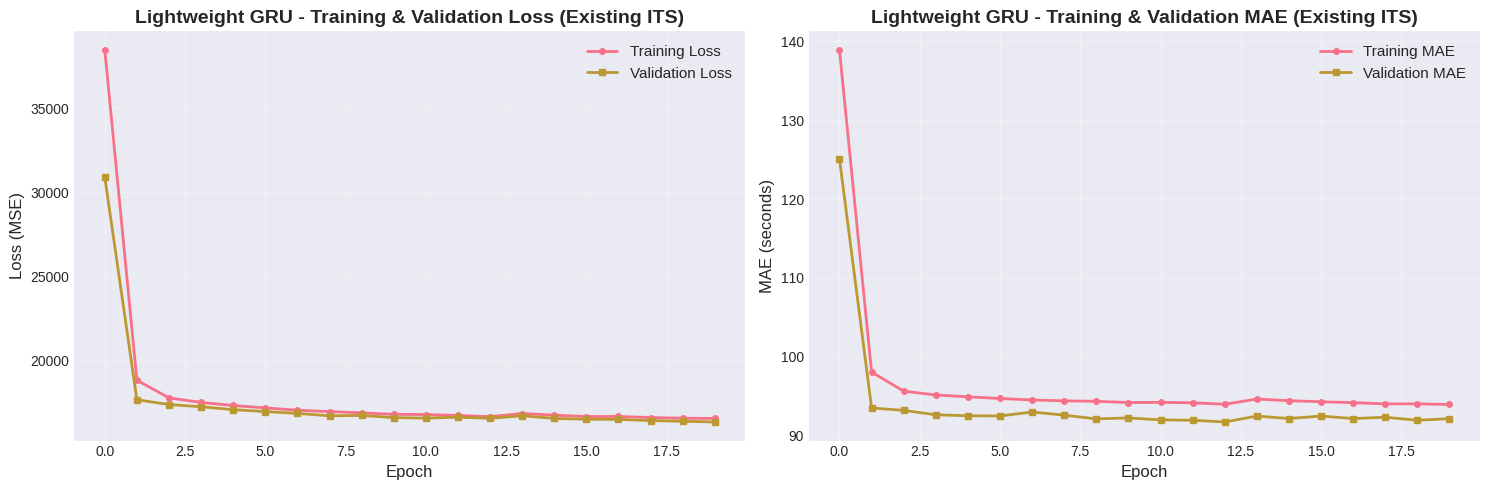

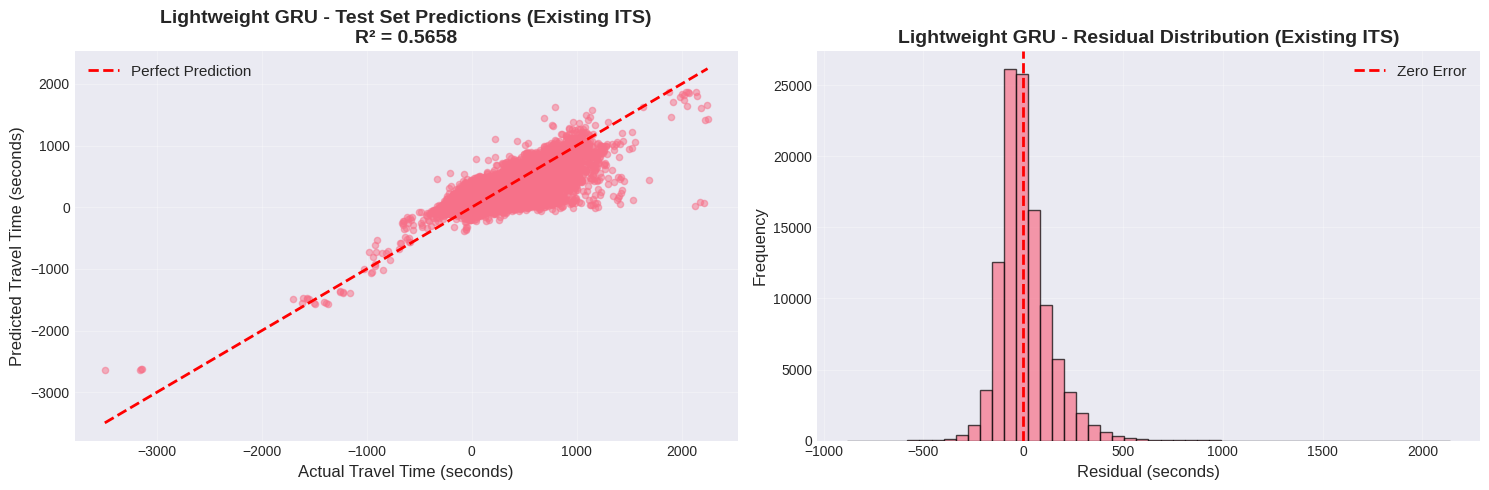

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("EXISTING ITS - GRU MODEL")


# 设置随机种子
tf.random.set_seed(RANDOM_STATE)

# 准备数据
X_train_gru_existing = X_train_existing_scaled.values.reshape(-1, X_train_existing_scaled.shape[1], 1)
X_test_gru_existing = X_test_existing_scaled.values.reshape(-1, X_test_existing_scaled.shape[1], 1)

gru_model_existing = models.Sequential([
    # 单层GRU（减少计算量）
    layers.GRU(32, return_sequences=False,
               input_shape=(X_train_gru_existing.shape[1], 1)),
    layers.Dropout(0.2),

    # 小型全连接层
    layers.Dense(8, activation='relu'),

    # 输出层
    layers.Dense(1)
])

# 编译模型
print("\nCompiling GRU model...")
print("  Optimizer: Adam (lr=0.01)")
print("  Loss: MSE")

gru_model_existing.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

# 模型摘要
print("\nModel Summary:")
gru_model_existing.summary()

# 计算参数量
total_params = gru_model_existing.count_params()
print(f"\nTotal Parameters: {total_params:,}")

# 回调函数
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.0001,
    verbose=1
)

# 训练模型
print(f"  Max epochs: 20 ")
print(f"  Batch size: 512 ")
print(f"  Early stopping patience: 5")

start_time = time.time()

history_gru_existing = gru_model_existing.fit(
    X_train_gru_existing, y_train_existing,
    validation_split=0.2,
    epochs=20,
    batch_size=512,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

training_time = time.time() - start_time
print(f"  Total epochs trained: {len(history_gru_existing.history['loss'])}")
print(f"  Final learning rate: {float(keras.backend.get_value(gru_model_existing.optimizer.learning_rate)):.6f}")

# 预测
y_train_pred_gru_existing = gru_model_existing.predict(X_train_gru_existing, batch_size=1024, verbose=0).flatten()
y_test_pred_gru_existing = gru_model_existing.predict(X_test_gru_existing, batch_size=1024, verbose=0).flatten()

# 计算评估指标
print("PERFORMANCE METRICS - EXISTING ITS")

# Training set metrics
train_r2_gru_existing = r2_score(y_train_existing, y_train_pred_gru_existing)
train_mae_gru_existing = mean_absolute_error(y_train_existing, y_train_pred_gru_existing)
train_rmse_gru_existing = np.sqrt(mean_squared_error(y_train_existing, y_train_pred_gru_existing))

print("\nTraining Set Performance:")
print(f"  R² Score:  {train_r2_gru_existing:.4f}")
print(f"  MAE:       {train_mae_gru_existing:.2f} seconds")
print(f"  RMSE:      {train_rmse_gru_existing:.2f} seconds")

# Test set metrics
test_r2_gru_existing = r2_score(y_test_existing, y_test_pred_gru_existing)
test_mae_gru_existing = mean_absolute_error(y_test_existing, y_test_pred_gru_existing)
test_rmse_gru_existing = np.sqrt(mean_squared_error(y_test_existing, y_test_pred_gru_existing))

print("\nTest Set Performance:")
print(f"  R² Score:  {test_r2_gru_existing:.4f}")
print(f"  MAE:       {test_mae_gru_existing:.2f} seconds")
print(f"  RMSE:      {test_rmse_gru_existing:.2f} seconds")

# 与其他模型对比
print("Model Comparison (Existing ITS):")

comparison_existing_gru = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'GRU (Fast)'],
    'R² Score': [
        f"{test_r2_lr_existing:.4f}",
        f"{test_r2_rf_existing:.4f}",
        f"{test_r2_xgb_existing:.4f}",
        f"{test_r2_gru_existing:.4f}"
    ],
    'MAE (seconds)': [
        f"{test_mae_lr_existing:.2f}",
        f"{test_mae_rf_existing:.2f}",
        f"{test_mae_xgb_existing:.2f}",
        f"{test_mae_gru_existing:.2f}"
    ],
    'RMSE (seconds)': [
        f"{test_rmse_lr_existing:.2f}",
        f"{test_rmse_rf_existing:.2f}",
        f"{test_rmse_xgb_existing:.2f}",
        f"{test_rmse_gru_existing:.2f}"
    ],
    'Training Time': [
        'N/A',
        'N/A',
        'N/A',
        f"{training_time:.1f}s"
    ]
})

print("\n" + comparison_existing_gru.to_string(index=False))

# 找出最佳模型
best_r2 = max(
    test_r2_lr_existing,
    test_r2_rf_existing,
    test_r2_xgb_existing,
    test_r2_gru_existing
)

if test_r2_gru_existing == best_r2:
    print(f"\nGRU is the BEST model!")
else:
    print(f"\nGRU Performance: {'Good' if test_r2_gru_existing > 0.8 else 'Acceptable'}")

# 训练历史可视化
print("Training History:")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss曲线
axes[0].plot(history_gru_existing.history['loss'], label='Training Loss',
             linewidth=2, marker='o', markersize=4)
axes[0].plot(history_gru_existing.history['val_loss'], label='Validation Loss',
             linewidth=2, marker='s', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Lightweight GRU - Training & Validation Loss (Existing ITS)',
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# MAE曲线
axes[1].plot(history_gru_existing.history['mae'], label='Training MAE',
             linewidth=2, marker='o', markersize=4)
axes[1].plot(history_gru_existing.history['val_mae'], label='Validation MAE',
             linewidth=2, marker='s', markersize=4)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE (seconds)', fontsize=12)
axes[1].set_title('Lightweight GRU - Training & Validation MAE (Existing ITS)',
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gru_fast_training_history_existing.png', dpi=300, bbox_inches='tight')
plt.show()


# 预测结果可视化

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Test set - 实际值 vs 预测值
axes[0].scatter(y_test_existing, y_test_pred_gru_existing, alpha=0.5, s=20)
axes[0].plot([y_test_existing.min(), y_test_existing.max()],
             [y_test_existing.min(), y_test_existing.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Travel Time (seconds)', fontsize=12)
axes[0].set_ylabel('Predicted Travel Time (seconds)', fontsize=12)
axes[0].set_title(f'Lightweight GRU - Test Set Predictions (Existing ITS)\nR² = {test_r2_gru_existing:.4f}',
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 残差分布
residuals = y_test_existing - y_test_pred_gru_existing
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Residual (seconds)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Lightweight GRU - Residual Distribution (Existing ITS)',
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gru_fast_predictions_existing.png', dpi=300, bbox_inches='tight')
plt.show()


### ad ITS

ADVANCED ITS - GRU MODEL

Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,633 (14.19 KB)

 Trainable params: 3,633 (14.19 KB)

 Non-trainable params: 0 (0.00 B)


Total Parameters: 3,633
Epoch 1/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 68s 92ms/step - loss: 41443.8945 - mae: 140.6827 - val_loss: 37868.4062 - val_mae: 140.2667 - learning_rate: 0.0100
Epoch 2/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 46s 67ms/step - loss: 28348.0781 - mae: 117.9557 - val_loss: 4570.7422 - val_mae: 36.9656 - learning_rate: 0.0100
Epoch 3/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 73s 55ms/step - loss: 4508.1704 - mae: 39.1674 - val_loss: 2617.3235 - val_mae: 32.8486 - learning_rate: 0.0100
Epoch 4/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - loss: 2961.9070 - mae: 30.6232 - val_loss: 2474.2014 - val_mae: 32.5614 - learning_rate: 0.0100
Epoch 5/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - loss: 2577.1602 - mae: 28.6124 - val_loss: 1335.0236 - val_mae: 16.1809 - learning_rate: 0.0100
Epoch 6/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - loss: 2335.4016 - mae: 27.4455 - val_loss: 1238.5597 - val_mae: 16.6782 - learning_rate: 0.0100
Epoch 7/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - l

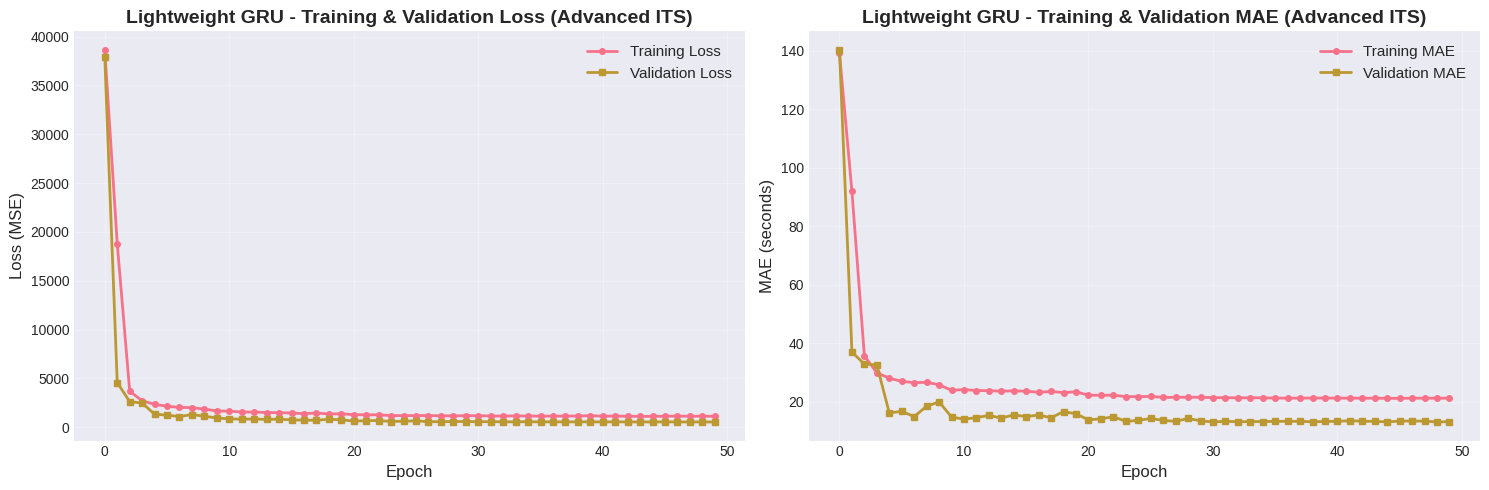

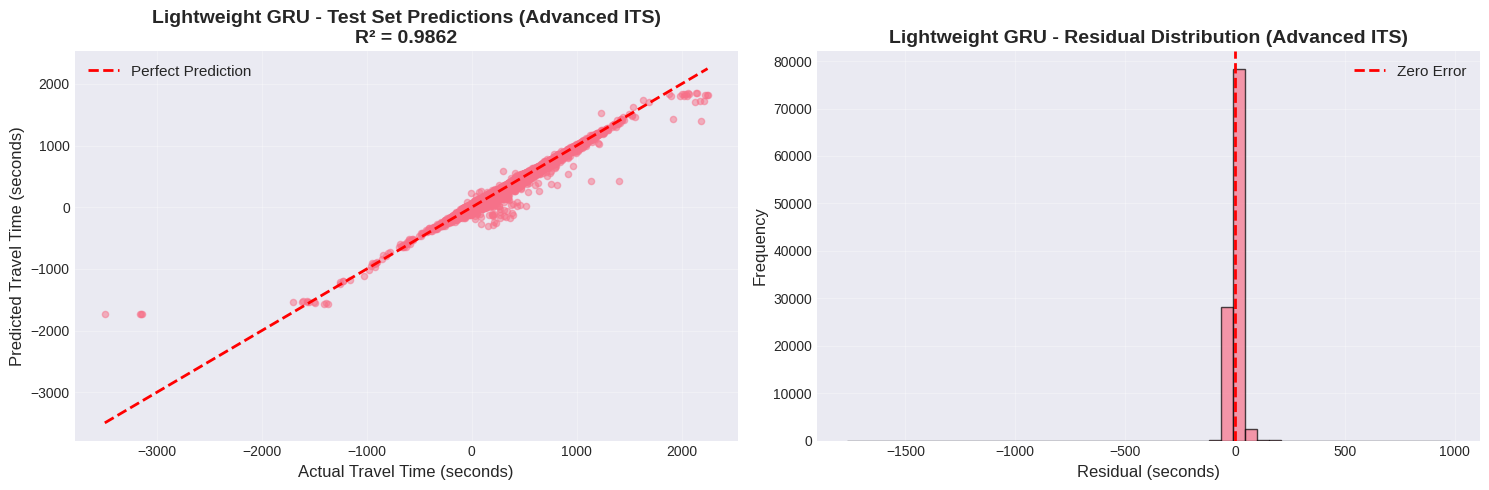

COMPARISON: EXISTING ITS vs ADVANCED ITS (GRU)

             Metric Existing ITS Advanced ITS Improvement
           R² Score       0.5658       0.9862      74.29%
      MAE (seconds)        92.28        13.19      85.70%
     RMSE (seconds)       127.41        22.74      82.16%
Training Time (sec)       2023.6       2023.6           -


In [22]:

print("ADVANCED ITS - GRU MODEL")

# 准备数据
X_train_gru_advanced = X_train_advanced_scaled.values.reshape(-1, X_train_advanced_scaled.shape[1], 1)
X_test_gru_advanced = X_test_advanced_scaled.values.reshape(-1, X_test_advanced_scaled.shape[1], 1)


# 构建GRU模型
gru_model_advanced = models.Sequential([
    layers.GRU(32, return_sequences=False,
               input_shape=(X_train_gru_advanced.shape[1], 1)),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)
])

# 编译模型
gru_model_advanced.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

print("\nModel Summary:")
gru_model_advanced.summary()

total_params = gru_model_advanced.count_params()
print(f"\nTotal Parameters: {total_params:,}")

# 回调函数
early_stopping_adv = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_adv = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.0001,
    verbose=1
)

# 训练模型
start_time = time.time()

history_gru_advanced = gru_model_advanced.fit(
    X_train_gru_advanced, y_train_advanced,
    validation_split=0.2,
    epochs=50,
    batch_size=512,
    callbacks=[early_stopping_adv, reduce_lr_adv],
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"  Total epochs trained: {len(history_gru_advanced.history['loss'])}")

# 预测

y_train_pred_gru_advanced = gru_model_advanced.predict(X_train_gru_advanced, batch_size=1024, verbose=0).flatten()
y_test_pred_gru_advanced = gru_model_advanced.predict(X_test_gru_advanced, batch_size=1024, verbose=0).flatten()

# 计算评估指标
print("PERFORMANCE METRICS - ADVANCED ITS")

# Training set metrics
train_r2_gru_advanced = r2_score(y_train_advanced, y_train_pred_gru_advanced)
train_mae_gru_advanced = mean_absolute_error(y_train_advanced, y_train_pred_gru_advanced)
train_rmse_gru_advanced = np.sqrt(mean_squared_error(y_train_advanced, y_train_pred_gru_advanced))

print("\nTraining Set Performance:")
print(f"  R² Score:  {train_r2_gru_advanced:.4f}")
print(f"  MAE:       {train_mae_gru_advanced:.2f} seconds")
print(f"  RMSE:      {train_rmse_gru_advanced:.2f} seconds")

# Test set metrics
test_r2_gru_advanced = r2_score(y_test_advanced, y_test_pred_gru_advanced)
test_mae_gru_advanced = mean_absolute_error(y_test_advanced, y_test_pred_gru_advanced)
test_rmse_gru_advanced = np.sqrt(mean_squared_error(y_test_advanced, y_test_pred_gru_advanced))

print("\nTest Set Performance:")
print(f"  R² Score:  {test_r2_gru_advanced:.4f}")
print(f"  MAE:       {test_mae_gru_advanced:.2f} seconds")
print(f"  RMSE:      {test_rmse_gru_advanced:.2f} seconds")

# 与其他模型对比
print("Model Comparison (Advanced ITS):")

comparison_advanced_gru = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'GRU (Fast)'],
    'R² Score': [
        f"{test_r2_lr_advanced:.4f}",
        f"{test_r2_rf_advanced:.4f}",
        f"{test_r2_xgb_advanced:.4f}",
        f"{test_r2_gru_advanced:.4f}"
    ],
    'MAE (seconds)': [
        f"{test_mae_lr_advanced:.2f}",
        f"{test_mae_rf_advanced:.2f}",
        f"{test_mae_xgb_advanced:.2f}",
        f"{test_mae_gru_advanced:.2f}"
    ],
    'RMSE (seconds)': [
        f"{test_rmse_lr_advanced:.2f}",
        f"{test_rmse_rf_advanced:.2f}",
        f"{test_rmse_xgb_advanced:.2f}",
        f"{test_rmse_gru_advanced:.2f}"
    ]
})

print("\n" + comparison_advanced_gru.to_string(index=False))

# 训练历史可视化
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_gru_advanced.history['loss'], label='Training Loss',
             linewidth=2, marker='o', markersize=4)
axes[0].plot(history_gru_advanced.history['val_loss'], label='Validation Loss',
             linewidth=2, marker='s', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Lightweight GRU - Training & Validation Loss (Advanced ITS)',
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_gru_advanced.history['mae'], label='Training MAE',
             linewidth=2, marker='o', markersize=4)
axes[1].plot(history_gru_advanced.history['val_mae'], label='Validation MAE',
             linewidth=2, marker='s', markersize=4)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE (seconds)', fontsize=12)
axes[1].set_title('Lightweight GRU - Training & Validation MAE (Advanced ITS)',
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gru_fast_training_history_advanced.png', dpi=300, bbox_inches='tight')
plt.show()


# 预测结果可视化
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(y_test_advanced, y_test_pred_gru_advanced, alpha=0.5, s=20)
axes[0].plot([y_test_advanced.min(), y_test_advanced.max()],
             [y_test_advanced.min(), y_test_advanced.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Travel Time (seconds)', fontsize=12)
axes[0].set_ylabel('Predicted Travel Time (seconds)', fontsize=12)
axes[0].set_title(f'Lightweight GRU - Test Set Predictions (Advanced ITS)\nR² = {test_r2_gru_advanced:.4f}',
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

residuals = y_test_advanced - y_test_pred_gru_advanced
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Residual (seconds)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Lightweight GRU - Residual Distribution (Advanced ITS)',
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gru_fast_predictions_advanced.png', dpi=300, bbox_inches='tight')
plt.show()


# 最终对比
print("COMPARISON: EXISTING ITS vs ADVANCED ITS (GRU)")

comparison_gru = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (seconds)', 'RMSE (seconds)', 'Training Time (sec)'],
    'Existing ITS': [
        f"{test_r2_gru_existing:.4f}",
        f"{test_mae_gru_existing:.2f}",
        f"{test_rmse_gru_existing:.2f}",
        f"{training_time:.1f}"
    ],
    'Advanced ITS': [
        f"{test_r2_gru_advanced:.4f}",
        f"{test_mae_gru_advanced:.2f}",
        f"{test_rmse_gru_advanced:.2f}",
        f"{training_time:.1f}"
    ],
    'Improvement': [
        f"{((test_r2_gru_advanced - test_r2_gru_existing) / test_r2_gru_existing * 100):.2f}%",
        f"{((test_mae_gru_existing - test_mae_gru_advanced) / test_mae_gru_existing * 100):.2f}%",
        f"{((test_rmse_gru_existing - test_rmse_gru_advanced) / test_rmse_gru_existing * 100):.2f}%",
        "-"
    ]
})

print("\n" + comparison_gru.to_string(index=False))

## LightGBM

### ITS

MODEL 5: LightGBM
EXISTING ITS

Parameter Candidates:

1. Baseline:
   num_leaves=31, lr=0.05, n_est=200

2. More Trees:
   num_leaves=31, lr=0.05, n_est=300

3. More Leaves:
   num_leaves=50, lr=0.05, n_est=200

4. Higher LR:
   num_leaves=31, lr=0.1, n_est=150

5. Complex:
   num_leaves=70, lr=0.03, n_est=300

[1/5] Testing: Baseline
  Train R²: 0.6128
  Test R²:  0.6076
  Test MAE: 87.65s
  Test RMSE: 121.14s

[2/5] Testing: More Trees
  Train R²: 0.6208
  Test R²:  0.6143
  Test MAE: 86.75s
  Test RMSE: 120.09s

[3/5] Testing: More Leaves
  Train R²: 0.6227
  Test R²:  0.6154
  Test MAE: 86.65s
  Test RMSE: 119.92s

[4/5] Testing: Higher LR
  Train R²: 0.6203
  Test R²:  0.6137
  Test MAE: 86.86s
  Test RMSE: 120.18s

[5/5] Testing: Complex
  Train R²: 0.6265
  Test R²:  0.6179
  Test MAE: 86.29s
  Test RMSE: 119.53s

Configuration Train R² Test R² MAE (s) RMSE (s) Time (s)
     Baseline   0.6128  0.6076   87.65   121.14     19.9
   More Trees   0.6208  0.6143   86.75   120.09     

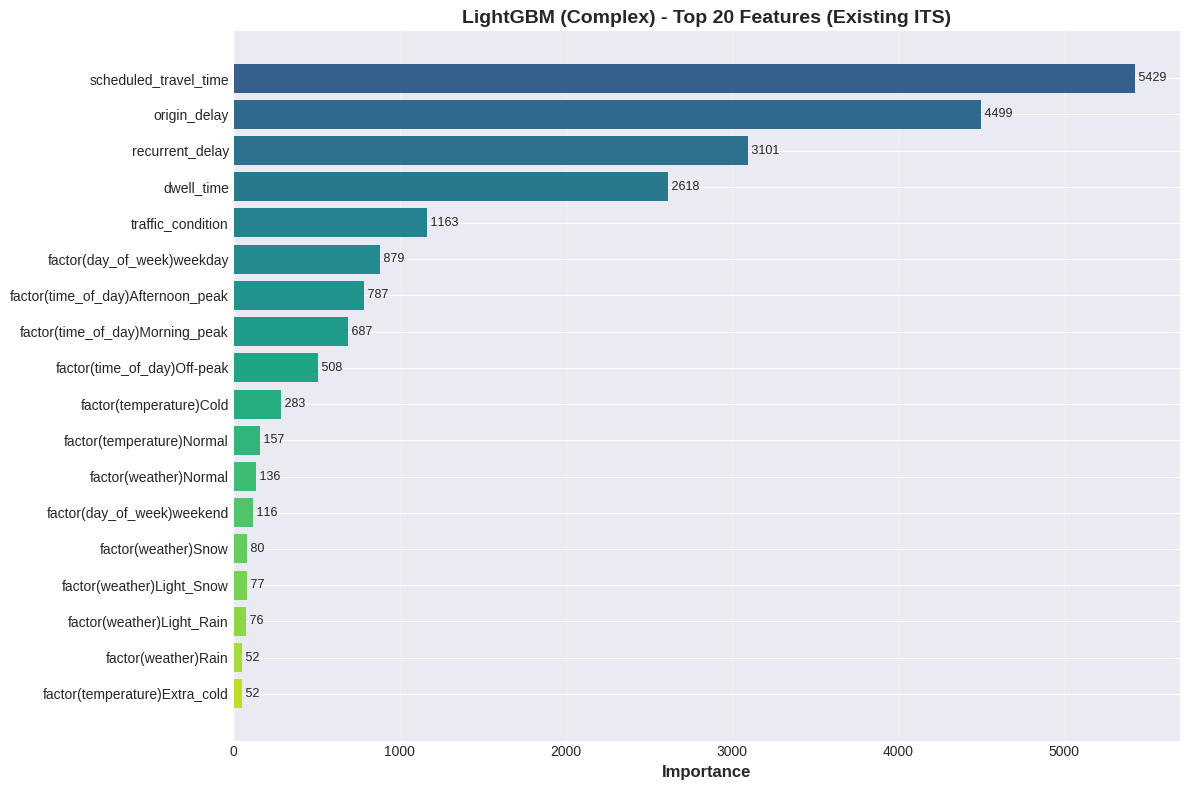

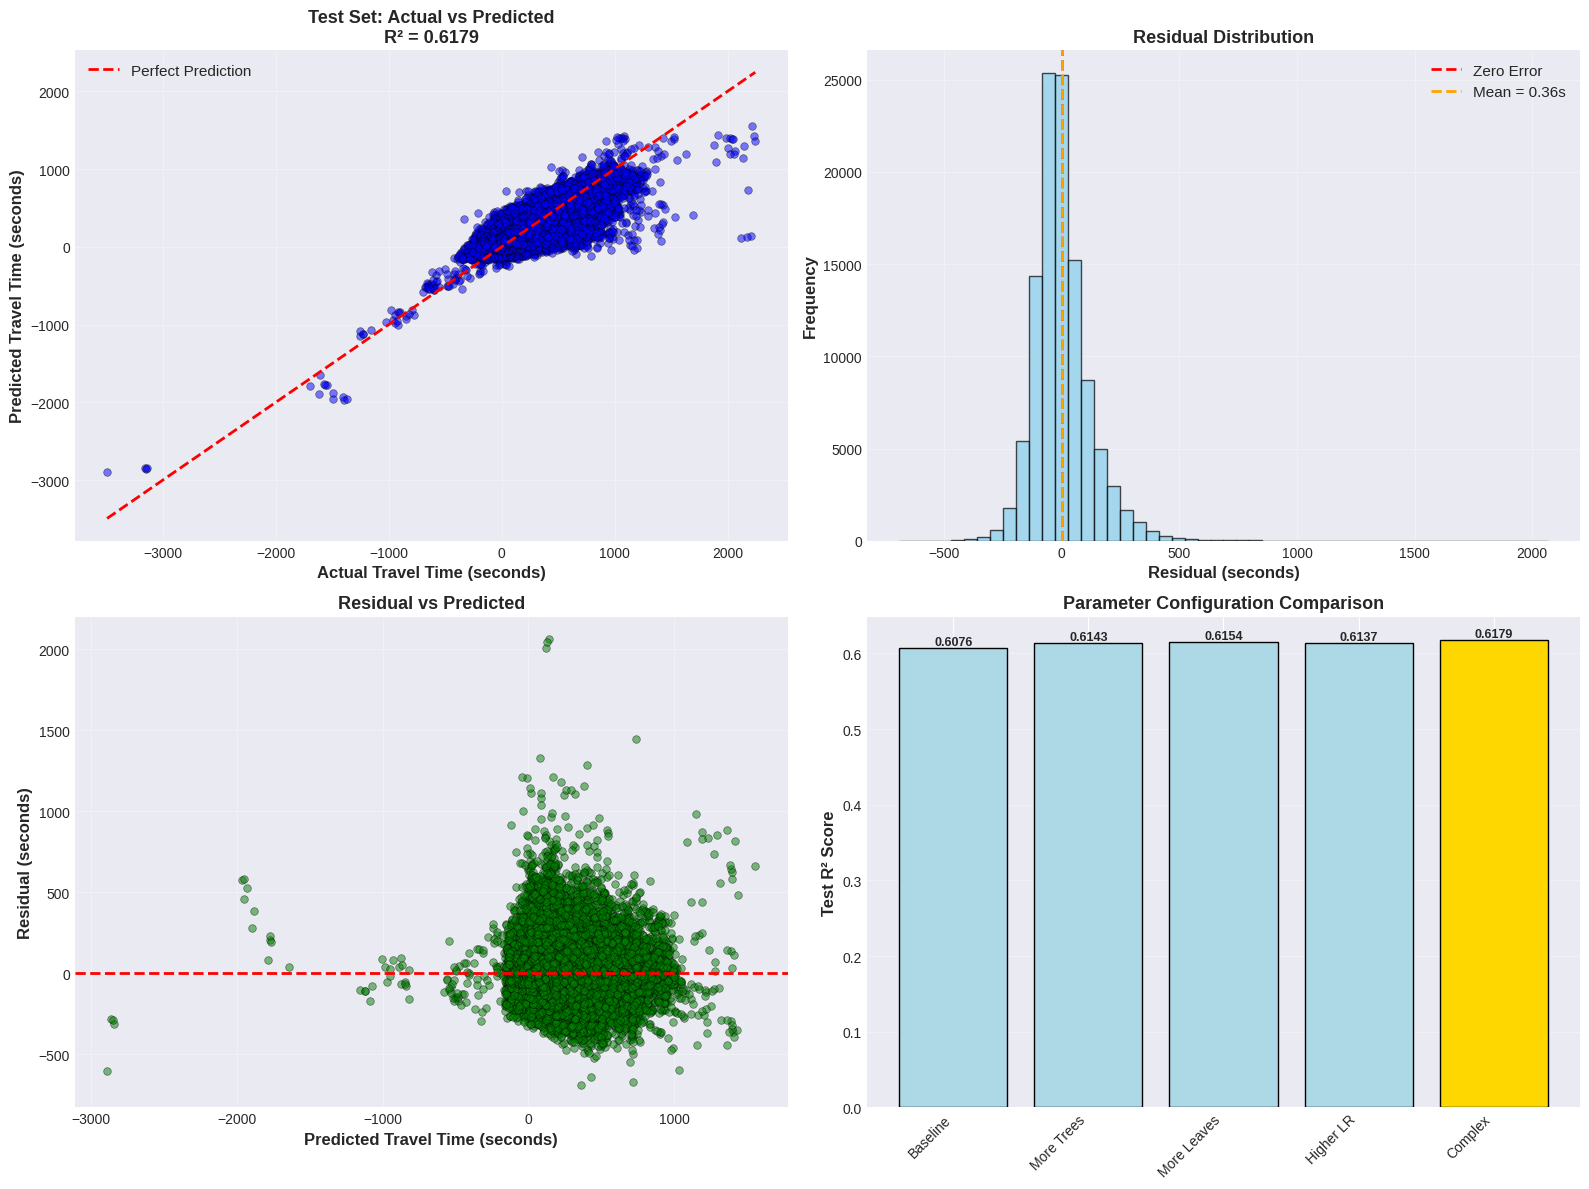

In [23]:
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import time

print("MODEL 5: LightGBM")
print("EXISTING ITS")

param_candidates = [
    {
        'name': 'Baseline',
        'params': {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'n_estimators': 200,
            'min_child_samples': 20,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': RANDOM_STATE,
            'verbose': -1
        }
    },
    {
        'name': 'More Trees',
        'params': {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'n_estimators': 300,
            'min_child_samples': 20,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': RANDOM_STATE,
            'verbose': -1
        }
    },
    {
        'name': 'More Leaves',
        'params': {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 50,
            'learning_rate': 0.05,
            'n_estimators': 200,
            'min_child_samples': 20,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': RANDOM_STATE,
            'verbose': -1
        }
    },
    {
        'name': 'Higher LR',
        'params': {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.1,
            'n_estimators': 150,
            'min_child_samples': 20,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': RANDOM_STATE,
            'verbose': -1
        }
    },
    {
        'name': 'Complex',
        'params': {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 70,
            'learning_rate': 0.03,
            'n_estimators': 300,
            'min_child_samples': 30,
            'subsample': 0.9,
            'colsample_bytree': 0.9,
            'random_state': RANDOM_STATE,
            'verbose': -1
        }
    }
]

print("\nParameter Candidates:")
for i, candidate in enumerate(param_candidates, 1):
    print(f"\n{i}. {candidate['name']}:")
    print(f"   num_leaves={candidate['params']['num_leaves']}, "
          f"lr={candidate['params']['learning_rate']}, "
          f"n_est={candidate['params']['n_estimators']}")

# 测试每个参数组合
results = []
start_time_total = time.time()

for i, candidate in enumerate(param_candidates, 1):
    print(f"\n[{i}/5] Testing: {candidate['name']}")
    start_time = time.time()

    # 训练模型
    model = lgb.LGBMRegressor(**candidate['params'])
    model.fit(X_train_existing_scaled, y_train_existing)

    # 预测
    y_train_pred = model.predict(X_train_existing_scaled)
    y_test_pred = model.predict(X_test_existing_scaled)

    # 评估
    train_r2 = r2_score(y_train_existing, y_train_pred)
    test_r2 = r2_score(y_test_existing, y_test_pred)
    test_mae = mean_absolute_error(y_test_existing, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_existing, y_test_pred))

    elapsed = time.time() - start_time

    results.append({
        'name': candidate['name'],
        'params': candidate['params'],
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'time': elapsed,
        'model': model
    })

    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Test MAE: {test_mae:.2f}s")
    print(f"  Test RMSE: {test_rmse:.2f}s")

total_time = time.time() - start_time_total

# 找出最佳模型
results_df = pd.DataFrame([{
    'Configuration': r['name'],
    'Train R²': f"{r['train_r2']:.4f}",
    'Test R²': f"{r['test_r2']:.4f}",
    'MAE (s)': f"{r['test_mae']:.2f}",
    'RMSE (s)': f"{r['test_rmse']:.2f}",
    'Time (s)': f"{r['time']:.1f}"
} for r in results])

print("\n" + results_df.to_string(index=False))

# 选择最佳模型
best_result = max(results, key=lambda x: x['test_r2'])
print(f"BEST CONFIGURATION: {best_result['name']}")
print("\nBest Parameters:")
for key, value in best_result['params'].items():
    if key not in ['objective', 'metric', 'boosting_type', 'random_state', 'verbose']:
        print(f"  {key}: {value}")

print(f"\nBest Performance:")
print(f"  Test R² Score: {best_result['test_r2']:.4f}")
print(f"  Test MAE:      {best_result['test_mae']:.2f} seconds")
print(f"  Test RMSE:     {best_result['test_rmse']:.2f} seconds")

# 使用最佳模型
lgb_model_existing = best_result['model']
y_train_pred_lgb_existing = lgb_model_existing.predict(X_train_existing_scaled)
y_test_pred_lgb_existing = lgb_model_existing.predict(X_test_existing_scaled)

# 保存指标
test_r2_lgb_existing = best_result['test_r2']
test_mae_lgb_existing = best_result['test_mae']
test_rmse_lgb_existing = best_result['test_rmse']
train_r2_lgb_existing = best_result['train_r2']
train_mae_lgb_existing = mean_absolute_error(y_train_existing, y_train_pred_lgb_existing)
train_rmse_lgb_existing = np.sqrt(mean_squared_error(y_train_existing, y_train_pred_lgb_existing))

# 与其他模型对比
print("Model Comparison (Existing ITS):")

comparison_existing_lgb = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM (Tuned)'],
    'R² Score': [
        f"{test_r2_lr_existing:.4f}",
        f"{test_r2_rf_existing:.4f}",
        f"{test_r2_xgb_existing:.4f}",
        f"{test_r2_lgb_existing:.4f}"
    ],
    'MAE (seconds)': [
        f"{test_mae_lr_existing:.2f}",
        f"{test_mae_rf_existing:.2f}",
        f"{test_mae_xgb_existing:.2f}",
        f"{test_mae_lgb_existing:.2f}"
    ],
    'RMSE (seconds)': [
        f"{test_rmse_lr_existing:.2f}",
        f"{test_rmse_rf_existing:.2f}",
        f"{test_rmse_xgb_existing:.2f}",
        f"{test_rmse_lgb_existing:.2f}"
    ]
})

print("\n" + comparison_existing_lgb.to_string(index=False))

# 找出最佳模型
best_r2 = max(
    test_r2_lr_existing,
    test_r2_rf_existing,
    test_r2_xgb_existing,
    test_r2_lgb_existing
)

if test_r2_lgb_existing == best_r2:
    print("\nLightGBM is the BEST model!")
    improvement = ((test_r2_lgb_existing - test_r2_lr_existing) / test_r2_lr_existing * 100)
    print(f"   Improvement over Linear Regression: {improvement:.2f}%")

# 特征重要性
print("Feature Importance (Top 15):")

feature_importance = pd.DataFrame({
    'Feature': X_train_existing_scaled.columns,
    'Importance': lgb_model_existing.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + feature_importance.head(15).to_string(index=False))

# 可视化特征重要性
fig, ax = plt.subplots(figsize=(12, 8))
top_features = feature_importance.head(20)
bars = ax.barh(range(len(top_features)), top_features['Importance'],
               color=plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features))))
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'], fontsize=10)
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title(f'LightGBM ({best_result["name"]}) - Top 20 Features (Existing ITS)',
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, top_features['Importance'])):
    ax.text(val, i, f' {val:.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('lgb_fast_tuned_feature_importance_existing.png', dpi=300, bbox_inches='tight')
plt.show()


# 预测可视化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 实际值 vs 预测值
axes[0, 0].scatter(y_test_existing, y_test_pred_lgb_existing, alpha=0.5, s=30,
                   c='blue', edgecolors='black', linewidth=0.5)
axes[0, 0].plot([y_test_existing.min(), y_test_existing.max()],
                [y_test_existing.min(), y_test_existing.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Travel Time (seconds)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Predicted Travel Time (seconds)', fontsize=12, fontweight='bold')
axes[0, 0].set_title(f'Test Set: Actual vs Predicted\nR² = {test_r2_lgb_existing:.4f}',
                     fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. 残差分布
residuals = y_test_existing - y_test_pred_lgb_existing
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 1].axvline(x=residuals.mean(), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean = {residuals.mean():.2f}s')
axes[0, 1].set_xlabel('Residual (seconds)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Residual Distribution', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. 残差 vs 预测值
axes[1, 0].scatter(y_test_pred_lgb_existing, residuals, alpha=0.5, s=30,
                   c='green', edgecolors='black', linewidth=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Travel Time (seconds)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Residual (seconds)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Residual vs Predicted', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. 参数对比柱状图
param_names = [r['name'] for r in results]
param_r2s = [r['test_r2'] for r in results]
colors = ['gold' if r['name'] == best_result['name'] else 'lightblue' for r in results]

axes[1, 1].bar(range(len(param_names)), param_r2s, color=colors, edgecolor='black')
axes[1, 1].set_xticks(range(len(param_names)))
axes[1, 1].set_xticklabels(param_names, rotation=45, ha='right')
axes[1, 1].set_ylabel('Test R² Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Parameter Configuration Comparison', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

for i, (name, r2) in enumerate(zip(param_names, param_r2s)):
    axes[1, 1].text(i, r2, f'{r2:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('lgb_fast_tuned_predictions_existing.png', dpi=300, bbox_inches='tight')
plt.show()


### ad ITS

ADVANCED ITS - LightGBM

[1/5] Testing: Baseline
21.8s | Test R²: 0.9855 | MAE: 13.55s

[2/5] Testing: More Trees
29.9s | Test R²: 0.9860 | MAE: 13.29s

[3/5] Testing: More Leaves
24.4s | Test R²: 0.9857 | MAE: 13.40s

[4/5] Testing: Higher LR
15.4s | Test R²: 0.9859 | MAE: 13.39s

[5/5] Testing: Complex
42.9s | Test R²: 0.9848 | MAE: 13.32s

Configuration Train R² Test R² MAE (s) RMSE (s) Time (s)
     Baseline   0.9879  0.9855   13.55    23.29     21.8
   More Trees   0.9888  0.9860   13.29    22.90     29.9
  More Leaves   0.9886  0.9857   13.40    23.16     24.4
    Higher LR   0.9888  0.9859   13.39    23.00     15.4
      Complex   0.9884  0.9848   13.32    23.86     42.9
BEST CONFIGURATION: More Trees

Best Performance:
  Test R² Score: 0.9860
  Test MAE:      13.29 seconds
  Test RMSE:     22.90 seconds
Model Comparison (Advanced ITS):

            Model R² Score MAE (seconds) RMSE (seconds)
Linear Regression   0.9894         12.58          19.93
    Random Forest   0.9637     

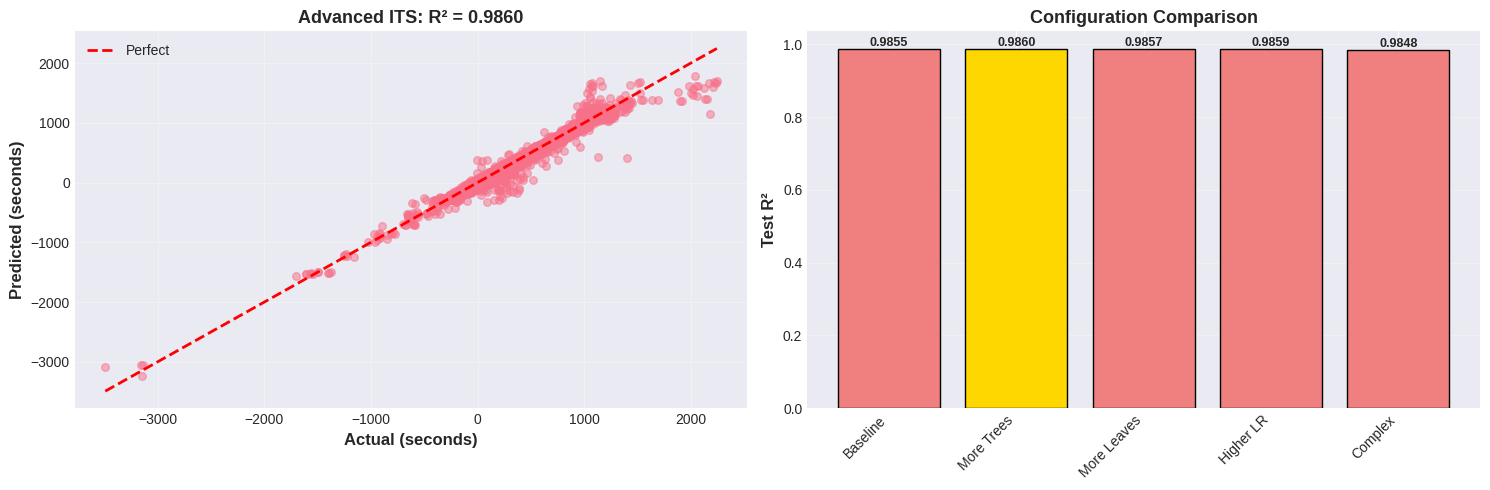

EXISTING vs ADVANCED ITS

     Metric Existing ITS Advanced ITS Improvement
   R² Score       0.6179       0.9860      59.57%
    MAE (s)        86.29        13.29      84.59%
   RMSE (s)       119.53        22.90      80.84%
Best Config      Complex   More Trees           -


In [24]:
print("ADVANCED ITS - LightGBM")
results_adv = []
start_time_total = time.time()

for i, candidate in enumerate(param_candidates, 1):
    print(f"\n[{i}/5] Testing: {candidate['name']}")

    start_time = time.time()

    model = lgb.LGBMRegressor(**candidate['params'])
    model.fit(X_train_advanced_scaled, y_train_advanced)

    y_train_pred = model.predict(X_train_advanced_scaled)
    y_test_pred = model.predict(X_test_advanced_scaled)

    train_r2 = r2_score(y_train_advanced, y_train_pred)
    test_r2 = r2_score(y_test_advanced, y_test_pred)
    test_mae = mean_absolute_error(y_test_advanced, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_advanced, y_test_pred))

    elapsed = time.time() - start_time

    results_adv.append({
        'name': candidate['name'],
        'params': candidate['params'],
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'time': elapsed,
        'model': model
    })

    print(f"{elapsed:.1f}s | Test R²: {test_r2:.4f} | MAE: {test_mae:.2f}s")

total_time_adv = time.time() - start_time_total


# 结果对比

results_adv_df = pd.DataFrame([{
    'Configuration': r['name'],
    'Train R²': f"{r['train_r2']:.4f}",
    'Test R²': f"{r['test_r2']:.4f}",
    'MAE (s)': f"{r['test_mae']:.2f}",
    'RMSE (s)': f"{r['test_rmse']:.2f}",
    'Time (s)': f"{r['time']:.1f}"
} for r in results_adv])

print("\n" + results_adv_df.to_string(index=False))

# 选择最佳模型
best_result_adv = max(results_adv, key=lambda x: x['test_r2'])

print(f"BEST CONFIGURATION: {best_result_adv['name']}")
print(f"\nBest Performance:")
print(f"  Test R² Score: {best_result_adv['test_r2']:.4f}")
print(f"  Test MAE:      {best_result_adv['test_mae']:.2f} seconds")
print(f"  Test RMSE:     {best_result_adv['test_rmse']:.2f} seconds")

# 使用最佳模型
lgb_model_advanced = best_result_adv['model']
y_train_pred_lgb_advanced = lgb_model_advanced.predict(X_train_advanced_scaled)
y_test_pred_lgb_advanced = lgb_model_advanced.predict(X_test_advanced_scaled)

test_r2_lgb_advanced = best_result_adv['test_r2']
test_mae_lgb_advanced = best_result_adv['test_mae']
test_rmse_lgb_advanced = best_result_adv['test_rmse']
train_r2_lgb_advanced = best_result_adv['train_r2']
train_mae_lgb_advanced = mean_absolute_error(y_train_advanced, y_train_pred_lgb_advanced)
train_rmse_lgb_advanced = np.sqrt(mean_squared_error(y_train_advanced, y_train_pred_lgb_advanced))

# 模型对比
print("Model Comparison (Advanced ITS):")
comparison_advanced_lgb = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM (Tuned)'],
    'R² Score': [
        f"{test_r2_lr_advanced:.4f}",
        f"{test_r2_rf_advanced:.4f}",
        f"{test_r2_xgb_advanced:.4f}",
        f"{test_r2_lgb_advanced:.4f}"
    ],
    'MAE (seconds)': [
        f"{test_mae_lr_advanced:.2f}",
        f"{test_mae_rf_advanced:.2f}",
        f"{test_mae_xgb_advanced:.2f}",
        f"{test_mae_lgb_advanced:.2f}"
    ],
    'RMSE (seconds)': [
        f"{test_rmse_lr_advanced:.2f}",
        f"{test_rmse_rf_advanced:.2f}",
        f"{test_rmse_xgb_advanced:.2f}",
        f"{test_rmse_lgb_advanced:.2f}"
    ]
})

print("\n" + comparison_advanced_lgb.to_string(index=False))

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 实际 vs 预测
axes[0].scatter(y_test_advanced, y_test_pred_lgb_advanced, alpha=0.5, s=30)
axes[0].plot([y_test_advanced.min(), y_test_advanced.max()],
             [y_test_advanced.min(), y_test_advanced.max()],
             'r--', lw=2, label='Perfect')
axes[0].set_xlabel('Actual (seconds)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted (seconds)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Advanced ITS: R² = {test_r2_lgb_advanced:.4f}',
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 参数对比
param_names_adv = [r['name'] for r in results_adv]
param_r2s_adv = [r['test_r2'] for r in results_adv]
colors_adv = ['gold' if r['name'] == best_result_adv['name'] else 'lightcoral' for r in results_adv]

axes[1].bar(range(len(param_names_adv)), param_r2s_adv, color=colors_adv, edgecolor='black')
axes[1].set_xticks(range(len(param_names_adv)))
axes[1].set_xticklabels(param_names_adv, rotation=45, ha='right')
axes[1].set_ylabel('Test R²', fontsize=12, fontweight='bold')
axes[1].set_title('Configuration Comparison', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for i, r2 in enumerate(param_r2s_adv):
    axes[1].text(i, r2, f'{r2:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('lgb_fast_tuned_advanced.png', dpi=300, bbox_inches='tight')
plt.show()

# 最终对比
print("EXISTING vs ADVANCED ITS")
final_comparison = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (s)', 'RMSE (s)', 'Best Config'],
    'Existing ITS': [
        f"{test_r2_lgb_existing:.4f}",
        f"{test_mae_lgb_existing:.2f}",
        f"{test_rmse_lgb_existing:.2f}",
        best_result['name']
    ],
    'Advanced ITS': [
        f"{test_r2_lgb_advanced:.4f}",
        f"{test_mae_lgb_advanced:.2f}",
        f"{test_rmse_lgb_advanced:.2f}",
        best_result_adv['name']
    ],
    'Improvement': [
        f"{((test_r2_lgb_advanced - test_r2_lgb_existing) / test_r2_lgb_existing * 100):.2f}%",
        f"{((test_mae_lgb_existing - test_mae_lgb_advanced) / test_mae_lgb_existing * 100):.2f}%",
        f"{((test_rmse_lgb_existing - test_rmse_lgb_advanced) / test_rmse_lgb_existing * 100):.2f}%",
        "-"
    ]
})

print("\n" + final_comparison.to_string(index=False))

## result

In [29]:
model_names_clean = ['Linear Regression', 'Random Forest', 'XGBoost', 'GRU', 'LightGBM']
print("VISUALIZATION")

# 图表 1: R² Score 对比柱状图
plt.figure(figsize=(14, 8))
x = np.arange(len(model_names_clean))
width = 0.35

bars1 = plt.bar(x - width/2, r2_values_existing, width, label='Existing ITS',
                color='steelblue', edgecolor='black', linewidth=1.5)
bars2 = plt.bar(x + width/2, r2_values_advanced, width, label='Advanced ITS',
                color='lightcoral', edgecolor='black', linewidth=1.5)

plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('R² Score', fontsize=14, fontweight='bold')
plt.title('R² Score Comparison: Existing ITS vs Advanced ITS', fontsize=16, fontweight='bold', pad=20)
plt.xticks(x, model_names_clean, rotation=45, ha='right', fontsize=12)
plt.legend(fontsize=13, loc='lower right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim([min(min(r2_values_existing), min(r2_values_advanced)) - 0.05, 1.0])

# 添加数值标签
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('chart_1_r2_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 图表 2: MAE 对比箱线图

plt.figure(figsize=(10, 8))
mae_comparison_data = pd.DataFrame({
    'ITS Type': ['Existing']*5 + ['Advanced']*5,
    'Model': model_names_clean * 2,
    'MAE': mae_values_existing + mae_values_advanced
})

import seaborn as sns
sns.boxplot(data=mae_comparison_data, x='ITS Type', y='MAE', palette=['steelblue', 'lightcoral'])
sns.stripplot(data=mae_comparison_data, x='ITS Type', y='MAE',
              color='black', alpha=0.5, size=8, jitter=True)

plt.xlabel('ITS Type', fontsize=14, fontweight='bold')
plt.ylabel('MAE (seconds)', fontsize=14, fontweight='bold')
plt.title('MAE Distribution: Existing ITS vs Advanced ITS', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('chart_2_mae_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 图表 3: 性能改进百分比

plt.figure(figsize=(12, 8))
r2_improvements = [(r2_values_advanced[i] - r2_values_existing[i]) / r2_values_existing[i] * 100
                   for i in range(5)]
colors_improvement = ['green' if x > 0 else 'red' for x in r2_improvements]

bars = plt.barh(model_names_clean, r2_improvements, color=colors_improvement,
                edgecolor='black', linewidth=1.5, alpha=0.7)
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)

plt.xlabel('R² Improvement (%)', fontsize=14, fontweight='bold')
plt.ylabel('Model', fontsize=14, fontweight='bold')
plt.title('Performance Improvement: Advanced ITS vs Existing ITS', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3, linestyle='--')

# 添加数值标签
for i, (bar, val) in enumerate(zip(bars, r2_improvements)):
    plt.text(val + (0.5 if val > 0 else -0.5), i, f'{val:+.2f}%',
             va='center', ha='left' if val > 0 else 'right',
             fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('chart_5_improvement_percentage.png', dpi=300, bbox_inches='tight')
plt.show()

# 图表 4: 雷达图 (归一化性能对比)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')

# 归一化R²到0-1范围
r2_existing_norm = (np.array(r2_values_existing) - min(r2_values_existing)) / \
                   (max(r2_values_existing) - min(r2_values_existing) + 1e-10)
r2_advanced_norm = (np.array(r2_values_advanced) - min(r2_values_advanced)) / \
                   (max(r2_values_advanced) - min(r2_values_advanced) + 1e-10)

angles = np.linspace(0, 2 * np.pi, len(model_names_clean), endpoint=False).tolist()
r2_existing_norm = r2_existing_norm.tolist()
r2_advanced_norm = r2_advanced_norm.tolist()

# 闭合图形
angles += angles[:1]
r2_existing_norm += r2_existing_norm[:1]
r2_advanced_norm += r2_advanced_norm[:1]

# 绘制
ax.plot(angles, r2_existing_norm, 'o-', linewidth=3, label='Existing ITS',
        color='steelblue', markersize=10)
ax.fill(angles, r2_existing_norm, alpha=0.25, color='steelblue')

ax.plot(angles, r2_advanced_norm, 'o-', linewidth=3, label='Advanced ITS',
        color='lightcoral', markersize=10)
ax.fill(angles, r2_advanced_norm, alpha=0.25, color='lightcoral')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(model_names_clean, fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_title('Normalized R² Performance Comparison\n(Radar Chart)',
             fontsize=16, fontweight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=13)
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('chart_8_radar.png', dpi=300, bbox_inches='tight')
plt.show()


# 图表 5: 综合排名对比

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Existing ITS 排名
sorted_idx_existing = np.argsort(r2_values_existing)[::-1]
sorted_models_existing = [model_names_clean[i] for i in sorted_idx_existing]
sorted_r2_existing = [r2_values_existing[i] for i in sorted_idx_existing]

colors_rank = ['gold', 'silver', '#CD7F32', 'lightblue', 'lightgray']
bars1 = ax1.barh(sorted_models_existing, sorted_r2_existing,
                 color=colors_rank, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('R² Score', fontsize=13, fontweight='bold')
ax1.set_title('Existing ITS - Model Ranking', fontsize=15, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# 添加数值标签和排名
for i, (bar, val) in enumerate(zip(bars1, sorted_r2_existing)):
    ax1.text(val + 0.01, i, f'{val:.4f}', va='center', fontsize=11, fontweight='bold')
    rank_text = f'#{i+1}'
    ax1.text(0.01, i, rank_text, va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black'))

# Advanced ITS 排名
sorted_idx_advanced = np.argsort(r2_values_advanced)[::-1]
sorted_models_advanced = [model_names_clean[i] for i in sorted_idx_advanced]
sorted_r2_advanced = [r2_values_advanced[i] for i in sorted_idx_advanced]

bars2 = ax2.barh(sorted_models_advanced, sorted_r2_advanced,
                 color=colors_rank, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('R² Score', fontsize=13, fontweight='bold')
ax2.set_title('Advanced ITS - Model Ranking', fontsize=15, fontweight='bold')
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# 添加数值标签和排名
for i, (bar, val) in enumerate(zip(bars2, sorted_r2_advanced)):
    ax2.text(val + 0.01, i, f'{val:.4f}', va='center', fontsize=11, fontweight='bold')
    rank_text = f'#{i+1}'
    ax2.text(0.01, i, rank_text, va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black'))

plt.suptitle('Model Performance Ranking by R² Score', fontsize=17, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('chart_9_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

# 图表 6: 所有指标综合对比 (分组柱状图)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# R² 对比
ax = axes[0, 0]
x = np.arange(len(model_names_clean))
width = 0.35
ax.bar(x - width/2, r2_values_existing, width, label='Existing', color='steelblue', edgecolor='black')
ax.bar(x + width/2, r2_values_advanced, width, label='Advanced', color='lightcoral', edgecolor='black')
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('R² Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names_clean, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# MAE 对比
ax = axes[0, 1]
ax.bar(x - width/2, mae_values_existing, width, label='Existing', color='steelblue', edgecolor='black')
ax.bar(x + width/2, mae_values_advanced, width, label='Advanced', color='lightcoral', edgecolor='black')
ax.set_ylabel('MAE (seconds)', fontsize=12, fontweight='bold')
ax.set_title('MAE Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names_clean, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# RMSE 对比
ax = axes[1, 0]
ax.bar(x - width/2, rmse_values_existing, width, label='Existing', color='steelblue', edgecolor='black')
ax.bar(x + width/2, rmse_values_advanced, width, label='Advanced', color='lightcoral', edgecolor='black')
ax.set_ylabel('RMSE (seconds)', fontsize=12, fontweight='bold')
ax.set_title('RMSE Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names_clean, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# 改进百分比汇总
ax = axes[1, 1]
r2_imp = [(r2_values_advanced[i] - r2_values_existing[i]) / r2_values_existing[i] * 100 for i in range(5)]
mae_imp = [(mae_values_existing[i] - mae_values_advanced[i]) / mae_values_existing[i] * 100 for i in range(5)]
rmse_imp = [(rmse_values_existing[i] - rmse_values_advanced[i]) / rmse_values_existing[i] * 100 for i in range(5)]

x_imp = np.arange(len(model_names_clean))
width_imp = 0.25
ax.bar(x_imp - width_imp, r2_imp, width_imp, label='R² Improvement', color='green', alpha=0.7, edgecolor='black')
ax.bar(x_imp, mae_imp, width_imp, label='MAE Improvement', color='blue', alpha=0.7, edgecolor='black')
ax.bar(x_imp + width_imp, rmse_imp, width_imp, label='RMSE Improvement', color='purple', alpha=0.7, edgecolor='black')
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax.set_ylabel('Improvement (%)', fontsize=12, fontweight='bold')
ax.set_title('Overall Improvement (Advanced vs Existing)', fontsize=14, fontweight='bold')
ax.set_xticks(x_imp)
ax.set_xticklabels(model_names_clean, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Comprehensive Performance Metrics Comparison', fontsize=17, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('chart_10_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()




VISUALIZATION


NameError: name 'r2_values_existing' is not defined

<Figure size 1400x800 with 0 Axes>

## 保存模型

In [25]:
import joblib
import json
import hashlib
import pandas as pd
from datetime import datetime

# 保存模型对象
joblib.dump(lgb_model_existing, 'lgb_model_existing_best.joblib')
print("模型已保存: lgb_model_existing_best.joblib")

# 保存训练和测试数据
# 保存训练数据
joblib.dump({
    'X_train': X_train_existing_scaled,
    'y_train': y_train_existing
}, 'train_data_existing.joblib')
print("训练数据已保存: /train_data_existing.joblib")

# 保存测试数据
joblib.dump({
    'X_test': X_test_existing_scaled,
    'y_test': y_test_existing
}, 'test_data_existing.joblib')
print("测试数据已保存: test_data_existing.joblib")

#保存最佳模型的性能指标
metrics_best = {
    'model_name': 'LightGBM',
    'configuration': best_result['name'],
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),

    # 训练集性能
    'train_metrics': {
        'r2': float(train_r2_lgb_existing),
        'mae': float(train_mae_lgb_existing),
        'rmse': float(train_rmse_lgb_existing)
    },

    # 测试集性能
    'test_metrics': {
        'r2': float(test_r2_lgb_existing),
        'mae': float(test_mae_lgb_existing),
        'rmse': float(test_rmse_lgb_existing)
    },

    # 数据信息
    'data_info': {
        'train_size': int(X_train_existing_scaled.shape[0]),
        'test_size': int(X_test_existing_scaled.shape[0]),
        'n_features': int(X_train_existing_scaled.shape[1]),
        'feature_names': list(X_train_existing_scaled.columns) if hasattr(X_train_existing_scaled, 'columns') else None
    },

    # 最佳参数
    'best_params': best_result['params'],

    # 训练时间
    'training_time': float(best_result['time'])
}

with open('metrics_best.json', 'w', encoding='utf-8') as f:
    json.dump(metrics_best, f, indent=4, ensure_ascii=False)
print("性能指标已保存: metrics_best.json")

#保存所有配置的结果

all_results = []
for r in results:
    all_results.append({
        'configuration': r['name'],
        'train_r2': float(r['train_r2']),
        'test_r2': float(r['test_r2']),
        'test_mae': float(r['test_mae']),
        'test_rmse': float(r['test_rmse']),
        'training_time': float(r['time']),
        'params': r['params']
    })

with open('all_configurations.json', 'w', encoding='utf-8') as f:
    json.dump(all_results, f, indent=4, ensure_ascii=False)
print("所有配置结果已保存: all_configurations.json")

模型已保存: lgb_model_existing_best.joblib
训练数据已保存: /train_data_existing.joblib
测试数据已保存: test_data_existing.joblib
性能指标已保存: metrics_best.json
所有配置结果已保存: all_configurations.json


# 鲁棒性测试

## 噪声，ITS

使用的模型和数据:
模型: LightGBM (Complex)
测试集大小: 109021 样本, 18 特征
y_test 类型: <class 'numpy.ndarray'>
y_test shape: (109021,)
原始测试集 R²: 0.6179
原始测试集 MAE: 86.29 seconds
噪声配置:
噪声水平: [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
说明: 0.1 表示噪声标准差 = 10% × 特征标准差

[噪声水平: 0.0%]
  使用原始数据（无噪声）
R² = 0.6179 (下降 0.0000)
MAE = 86.29s (增加 0.00s)
RMSE = 119.53s (增加 0.00s)

[噪声水平: 1.0%]
添加高斯噪声 (σ = 1.0% × feature_std)
R² = 0.5726 (下降 0.0453)
MAE = 92.24s (增加 5.95s)
RMSE = 126.42s (增加 6.89s)

[噪声水平: 5.0%]
添加高斯噪声 (σ = 5.0% × feature_std)
R² = 0.5455 (下降 0.0724)
MAE = 95.91s (增加 9.62s)
RMSE = 130.36s (增加 10.83s)

[噪声水平: 10.0%]
添加高斯噪声 (σ = 10.0% × feature_std)
R² = 0.5250 (下降 0.0929)
MAE = 98.66s (增加 12.37s)
RMSE = 133.28s (增加 13.74s)

[噪声水平: 20.0%]
添加高斯噪声 (σ = 20.0% × feature_std)
R² = 0.4829 (下降 0.1350)
MAE = 104.02s (增加 17.73s)
RMSE = 139.06s (增加 19.52s)

[噪声水平: 30.0%]
添加高斯噪声 (σ = 30.0% × feature_std)
R² = 0.4366 (下降 0.1813)
MAE = 109.51s (增加 23.22s)
RMSE = 145.14s (增加 25.61s)

[噪声水平: 50.0%]
添加高斯噪声 (σ = 50.0% × feature_std)

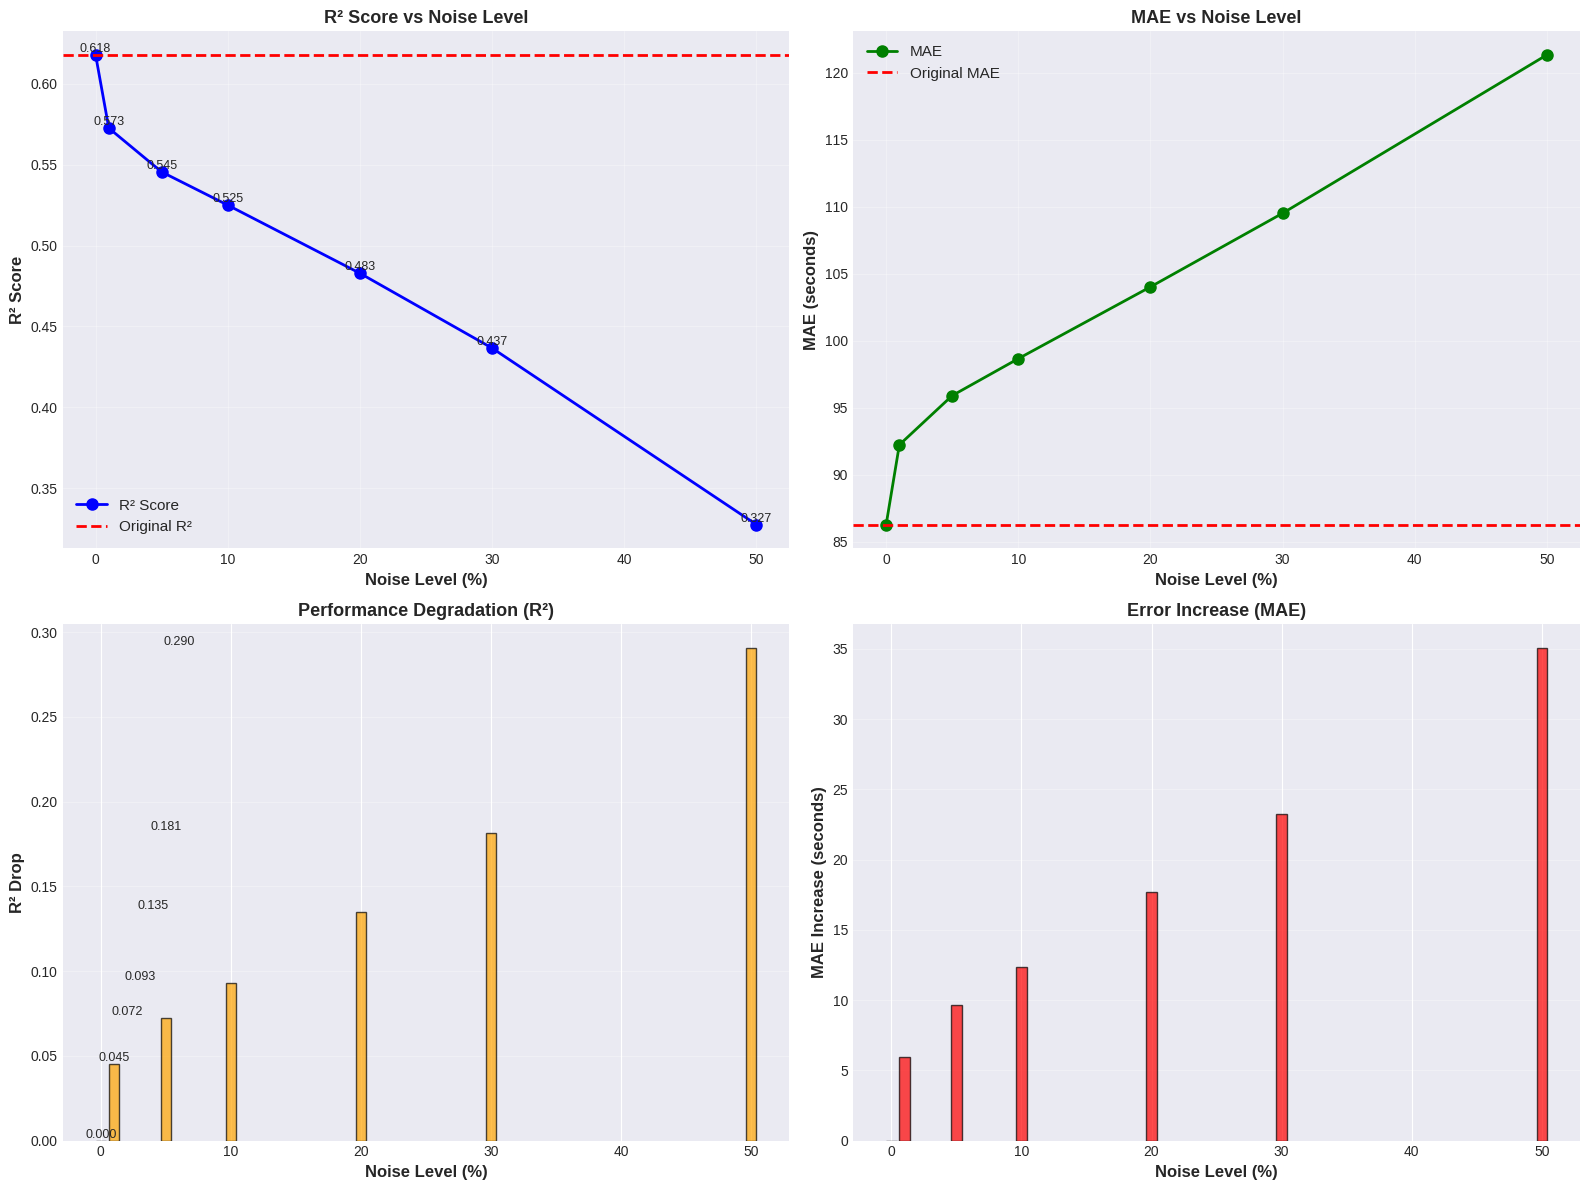

鲁棒性评估:

在 10% 噪声水平下:
  R² = 0.5250 (下降 0.0929)
  R² 保留率: 84.96%

噪声鲁棒性评级: 良好 (Good)
评价: 模型对噪声有一定抵抗力


In [31]:
# 鲁棒性测试 1: 噪声鲁棒性 (Noise Robustness)
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

print("使用的模型和数据:")

# 最佳模型
model_robust = lgb_model_existing
print(f"模型: LightGBM ({best_result['name']})")

# 测试数据 - 使用明确的变量名
X_test_robust = X_test_existing_scaled.copy()
y_test_robust = y_test_existing

print(f"测试集大小: {X_test_robust.shape[0]} 样本, {X_test_robust.shape[1]} 特征")
print(f"y_test 类型: {type(y_test_robust)}")
print(f"y_test shape: {y_test_robust.shape if hasattr(y_test_robust, 'shape') else len(y_test_robust)}")

# 原始性能
print(f"原始测试集 R²: {test_r2_lgb_existing:.4f}")
print(f"原始测试集 MAE: {test_mae_lgb_existing:.2f} seconds")


print("噪声配置:")

# 噪声水平：相对于特征标准差的百分比
noise_levels = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
print(f"噪声水平: {noise_levels}")
print("说明: 0.1 表示噪声标准差 = 10% × 特征标准差")

results_noise = []

for noise_level in noise_levels:
    print(f"\n[噪声水平: {noise_level*100:.1f}%]")

    if noise_level == 0:
        # 无噪声（原始数据）
        X_test_noisy = X_test_robust.copy()
        print("  使用原始数据（无噪声）")
    else:
        # 添加高斯噪声
        X_test_noisy = X_test_robust.copy()

        # 计算每个特征的标准差
        if isinstance(X_test_robust, pd.DataFrame):
            feature_stds = X_test_robust.std(axis=0).values
        else:
            feature_stds = np.std(X_test_robust, axis=0)

        # 生成噪声
        np.random.seed(42)  # 设置随机种子以保证可重复性
        noise = np.random.normal(0, 1, X_test_robust.shape)

        # 缩放噪声
        for i in range(X_test_robust.shape[1]):
            noise[:, i] *= feature_stds[i] * noise_level

        # 添加噪声
        if isinstance(X_test_noisy, pd.DataFrame):
            X_test_noisy = X_test_noisy.values + noise
            X_test_noisy = pd.DataFrame(X_test_noisy,
                                        columns=X_test_robust.columns,
                                        index=X_test_robust.index)
        else:
            X_test_noisy = X_test_noisy + noise

        print(f"添加高斯噪声 (σ = {noise_level*100:.1f}% × feature_std)")

    # 预测
    y_pred_noisy = model_robust.predict(X_test_noisy)

    # 确保 y_test_robust 是数组格式
    if isinstance(y_test_robust, pd.Series):
        y_test_array = y_test_robust.values
    else:
        y_test_array = np.array(y_test_robust)

    # 计算指标
    r2_noisy = r2_score(y_test_array, y_pred_noisy)
    mae_noisy = mean_absolute_error(y_test_array, y_pred_noisy)
    rmse_noisy = np.sqrt(mean_squared_error(y_test_array, y_pred_noisy))

    # 计算性能下降
    r2_drop = test_r2_lgb_existing - r2_noisy
    mae_increase = mae_noisy - test_mae_lgb_existing
    rmse_increase = rmse_noisy - test_rmse_lgb_existing

    # 保存结果
    results_noise.append({
        'noise_level': noise_level,
        'noise_pct': noise_level * 100,
        'r2': r2_noisy,
        'mae': mae_noisy,
        'rmse': rmse_noisy,
        'r2_drop': r2_drop,
        'mae_increase': mae_increase,
        'rmse_increase': rmse_increase
    })

    print(f"R² = {r2_noisy:.4f} (下降 {r2_drop:.4f})")
    print(f"MAE = {mae_noisy:.2f}s (增加 {mae_increase:.2f}s)")
    print(f"RMSE = {rmse_noisy:.2f}s (增加 {rmse_increase:.2f}s)")


print("噪声鲁棒性测试结果:")

results_noise_df = pd.DataFrame(results_noise)

print("\n详细结果:")
print(results_noise_df.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R² vs 噪声水平
axes[0, 0].plot(results_noise_df['noise_pct'], results_noise_df['r2'],
                'o-', linewidth=2, markersize=8, color='blue', label='R² Score')
axes[0, 0].axhline(y=test_r2_lgb_existing, color='red', linestyle='--',
                   linewidth=2, label='Original R²')
axes[0, 0].set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('R² Score vs Noise Level', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 添加数值标签
for i, row in results_noise_df.iterrows():
    axes[0, 0].text(row['noise_pct'], row['r2'], f"{row['r2']:.3f}",
                    ha='center', va='bottom', fontsize=9)

# 2. MAE vs 噪声水平
axes[0, 1].plot(results_noise_df['noise_pct'], results_noise_df['mae'],
                'o-', linewidth=2, markersize=8, color='green', label='MAE')
axes[0, 1].axhline(y=test_mae_lgb_existing, color='red', linestyle='--',
                   linewidth=2, label='Original MAE')
axes[0, 1].set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('MAE (seconds)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('MAE vs Noise Level', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. 性能下降（R²）
axes[1, 0].bar(results_noise_df['noise_pct'], results_noise_df['r2_drop'],
               color='orange', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('R² Drop', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Performance Degradation (R²)', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 添加数值标签
for i, row in results_noise_df.iterrows():
    axes[1, 0].text(i, row['r2_drop'], f"{row['r2_drop']:.3f}",
                    ha='center', va='bottom', fontsize=9)

# 4. 误差增加（MAE）
axes[1, 1].bar(results_noise_df['noise_pct'], results_noise_df['mae_increase'],
               color='red', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('MAE Increase (seconds)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Error Increase (MAE)', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('robustness_test_1_noise.png', dpi=300, bbox_inches='tight')
plt.show()


print("鲁棒性评估:")
# 在 10% 噪声下的性能
noise_10_result = results_noise_df[results_noise_df['noise_pct'] == 10.0].iloc[0]
r2_at_10 = noise_10_result['r2']
r2_drop_at_10 = noise_10_result['r2_drop']

print(f"\n在 10% 噪声水平下:")
print(f"  R² = {r2_at_10:.4f} (下降 {r2_drop_at_10:.4f})")
print(f"  R² 保留率: {(r2_at_10/test_r2_lgb_existing)*100:.2f}%")

# 评级
if r2_drop_at_10 < 0.05:
    rating = "优秀 (Excellent)"
    comment = "模型对噪声非常鲁棒"
elif r2_drop_at_10 < 0.10:
    rating = "良好 (Good)"
    comment = "模型对噪声有一定抵抗力"
elif r2_drop_at_10 < 0.20:
    rating = "一般 (Fair)"
    comment = "模型对噪声较为敏感"
else:
    rating = "较差 (Poor)"
    comment = "模型对噪声非常敏感"

print(f"\n噪声鲁棒性评级: {rating}")
print(f"评价: {comment}")


1. 低噪声表现好

1% 噪声：R² 仅下降 0.045（7.3%）
5% 噪声：R² 下降 0.072（11.7%）
说明模型对小幅度扰动有一定抵抗力

2. 10% 噪声可接受

R² 保留率：85% (0.5250/0.6179)
MAE 增加：12.37s (14.3%)
在实际应用中，10% 的测量误差是常见的

3. 中高噪声敏感

20% 噪声：R² 下降 21.8%
30% 噪声：R² 下降 29.3%
表明模型对较大扰动较为敏感

## 噪声，ad ITS

使用的模型和数据:
模型: Linear (Complex)
原始测试集 R²: 0.9894
原始测试集 MAE: 12.58 seconds
噪声水平: [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

[噪声水平: 0.0%]
  使用原始数据（无噪声）
  R² = 0.9894 (下降 0.0000)
  MAE = 12.58s (增加 0.00s)
  RMSE = 19.93s (增加 0.00s)

[噪声水平: 1.0%]
添加高斯噪声 (σ = 1.0% × feature_std)
  R² = 0.9893 (下降 0.0001)
  MAE = 12.70s (增加 0.11s)
  RMSE = 20.03s (增加 0.09s)

[噪声水平: 5.0%]
添加高斯噪声 (σ = 5.0% × feature_std)
  R² = 0.9868 (下降 0.0026)
  MAE = 15.16s (增加 2.57s)
  RMSE = 22.22s (增加 2.29s)

[噪声水平: 10.0%]
添加高斯噪声 (σ = 10.0% × feature_std)
  R² = 0.9790 (下降 0.0104)
  MAE = 20.72s (增加 8.14s)
  RMSE = 28.02s (增加 8.08s)

[噪声水平: 20.0%]
添加高斯噪声 (σ = 20.0% × feature_std)
  R² = 0.9479 (下降 0.0415)
  MAE = 34.48s (增加 21.90s)
  RMSE = 44.15s (增加 24.22s)

[噪声水平: 30.0%]
添加高斯噪声 (σ = 30.0% × feature_std)
  R² = 0.8959 (下降 0.0935)
  MAE = 49.35s (增加 36.77s)
  RMSE = 62.38s (增加 42.45s)

[噪声水平: 50.0%]
添加高斯噪声 (σ = 50.0% × feature_std)
  R² = 0.7297 (下降 0.2597)
  MAE = 80.03s (增加 67.44s)
  RMSE = 100.53s (增加 80.60s)

结果:
 noise_l

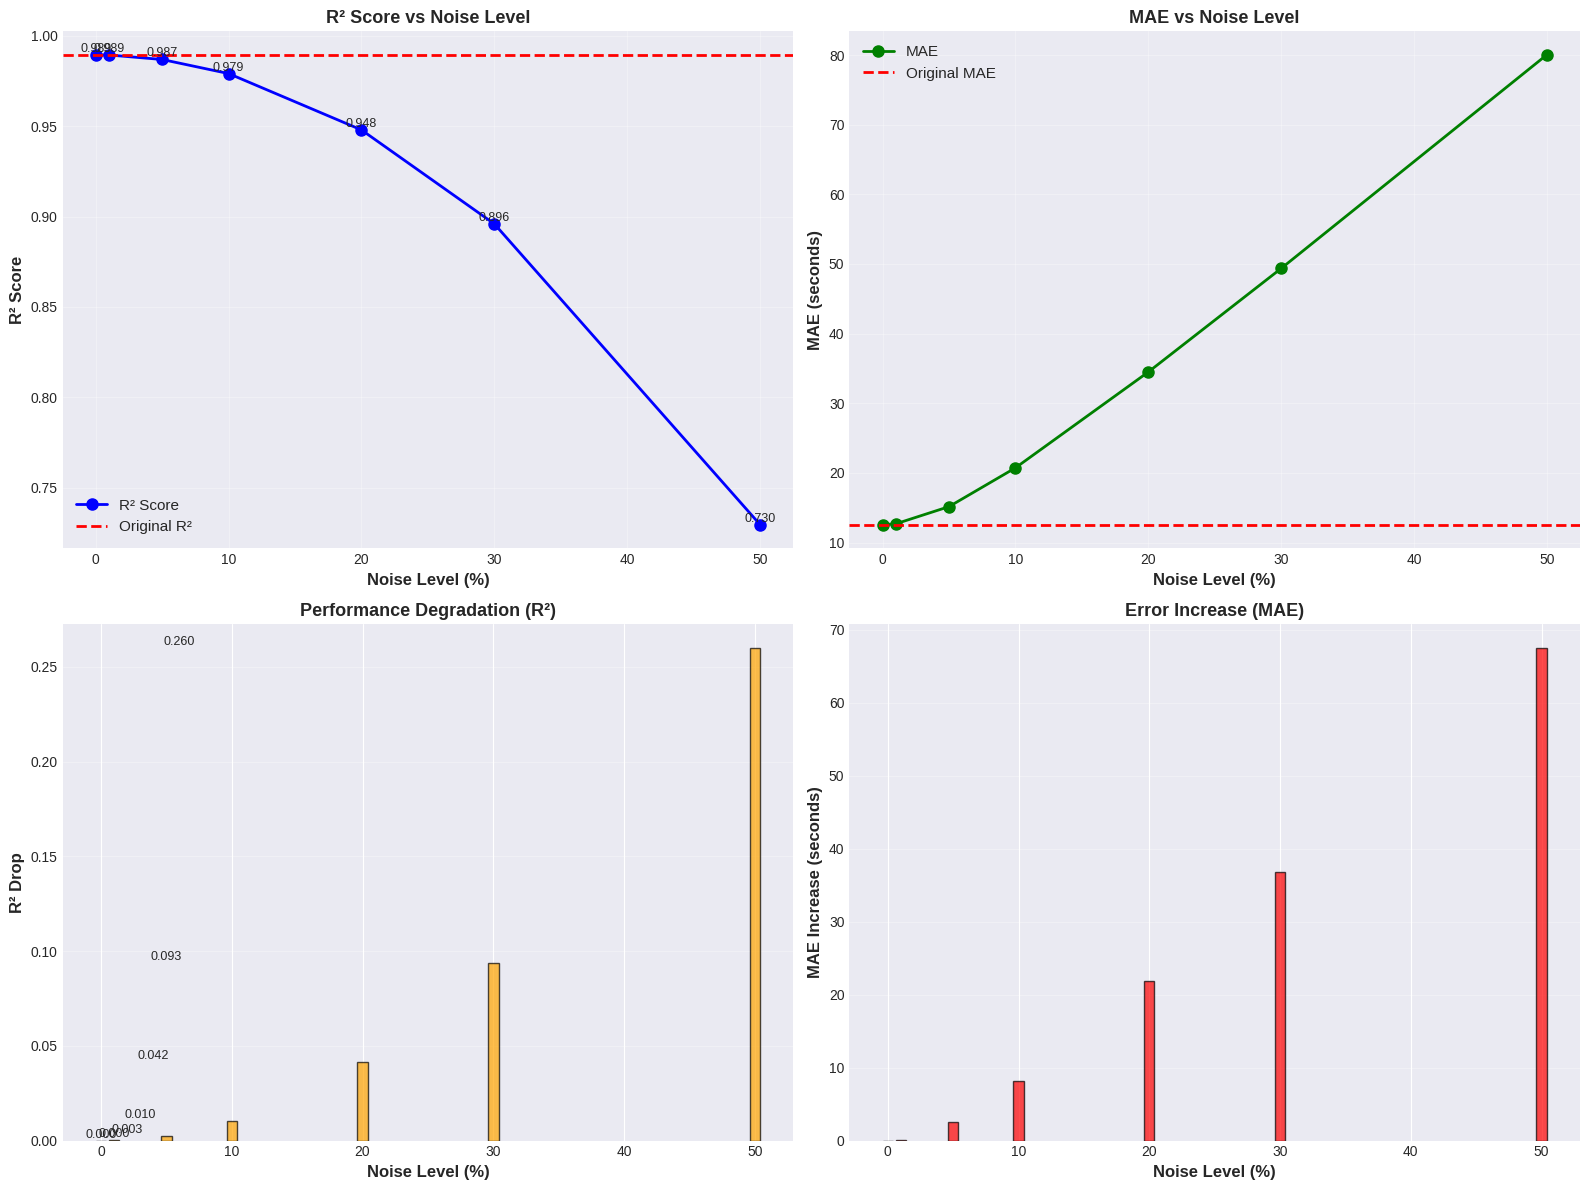


在 10% 噪声水平下:
  R² = 0.9790 (下降 0.0104)
  R² 保留率: 98.95%

噪声鲁棒性评级: 优秀 (Excellent)
评价: 模型对噪声非常鲁棒


In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

print("使用的模型和数据:")
# 最佳模型
model_robust = lr_model_advanced
print(f"模型: Linear ({best_result['name']})")

# 测试数据 - 使用明确的变量名
X_test_robust = X_test_advanced_scaled.copy()
y_test_robust = y_test_advanced

# 原始性能
print(f"原始测试集 R²: {test_r2_lr_advanced:.4f}")
print(f"原始测试集 MAE: {test_mae_lr_advanced:.2f} seconds")


# 噪声水平：相对于特征标准差的百分比
noise_levels = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
print(f"噪声水平: {noise_levels}")


results_noise = []

for noise_level in noise_levels:
    print(f"\n[噪声水平: {noise_level*100:.1f}%]")

    if noise_level == 0:
        # 无噪声（原始数据）
        X_test_noisy = X_test_robust.copy()
        print("  使用原始数据（无噪声）")
    else:
        # 添加高斯噪声
        X_test_noisy = X_test_robust.copy()

        # 计算每个特征的标准差
        if isinstance(X_test_robust, pd.DataFrame):
            feature_stds = X_test_robust.std(axis=0).values
        else:
            feature_stds = np.std(X_test_robust, axis=0)

        # 生成噪声
        np.random.seed(42)  # 设置随机种子以保证可重复性
        noise = np.random.normal(0, 1, X_test_robust.shape)

        # 缩放噪声
        for i in range(X_test_robust.shape[1]):
            noise[:, i] *= feature_stds[i] * noise_level

        # 添加噪声
        if isinstance(X_test_noisy, pd.DataFrame):
            X_test_noisy = X_test_noisy.values + noise
            X_test_noisy = pd.DataFrame(X_test_noisy,
                                        columns=X_test_robust.columns,
                                        index=X_test_robust.index)
        else:
            X_test_noisy = X_test_noisy + noise

        print(f"添加高斯噪声 (σ = {noise_level*100:.1f}% × feature_std)")

    # 预测
    y_pred_noisy = model_robust.predict(X_test_noisy)

    # 确保 y_test_robust 是数组格式
    if isinstance(y_test_robust, pd.Series):
        y_test_array = y_test_robust.values
    else:
        y_test_array = np.array(y_test_robust)

    # 计算指标
    r2_noisy = r2_score(y_test_array, y_pred_noisy)
    mae_noisy = mean_absolute_error(y_test_array, y_pred_noisy)
    rmse_noisy = np.sqrt(mean_squared_error(y_test_array, y_pred_noisy))

    # 计算性能下降
    r2_drop = test_r2_lr_advanced - r2_noisy
    mae_increase = mae_noisy - test_mae_lr_advanced
    rmse_increase = rmse_noisy - test_rmse_lr_advanced

    # 保存结果
    results_noise.append({
        'noise_level': noise_level,
        'noise_pct': noise_level * 100,
        'r2': r2_noisy,
        'mae': mae_noisy,
        'rmse': rmse_noisy,
        'r2_drop': r2_drop,
        'mae_increase': mae_increase,
        'rmse_increase': rmse_increase
    })

    print(f"  R² = {r2_noisy:.4f} (下降 {r2_drop:.4f})")
    print(f"  MAE = {mae_noisy:.2f}s (增加 {mae_increase:.2f}s)")
    print(f"  RMSE = {rmse_noisy:.2f}s (增加 {rmse_increase:.2f}s)")


results_noise_df = pd.DataFrame(results_noise)

print("\n结果:")
print(results_noise_df.to_string(index=False))


fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R² vs 噪声水平
axes[0, 0].plot(results_noise_df['noise_pct'], results_noise_df['r2'],
                'o-', linewidth=2, markersize=8, color='blue', label='R² Score')
axes[0, 0].axhline(y=test_r2_lr_advanced, color='red', linestyle='--',
                   linewidth=2, label='Original R²')
axes[0, 0].set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('R² Score vs Noise Level', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 添加数值标签
for i, row in results_noise_df.iterrows():
    axes[0, 0].text(row['noise_pct'], row['r2'], f"{row['r2']:.3f}",
                    ha='center', va='bottom', fontsize=9)

# 2. MAE vs 噪声水平
axes[0, 1].plot(results_noise_df['noise_pct'], results_noise_df['mae'],
                'o-', linewidth=2, markersize=8, color='green', label='MAE')
axes[0, 1].axhline(y=test_mae_lr_advanced, color='red', linestyle='--',
                   linewidth=2, label='Original MAE')
axes[0, 1].set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('MAE (seconds)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('MAE vs Noise Level', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. 性能下降（R²）
axes[1, 0].bar(results_noise_df['noise_pct'], results_noise_df['r2_drop'],
               color='orange', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('R² Drop', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Performance Degradation (R²)', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 添加数值标签
for i, row in results_noise_df.iterrows():
    axes[1, 0].text(i, row['r2_drop'], f"{row['r2_drop']:.3f}",
                    ha='center', va='bottom', fontsize=9)

# 4. 误差增加（MAE）
axes[1, 1].bar(results_noise_df['noise_pct'], results_noise_df['mae_increase'],
               color='red', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('MAE Increase (seconds)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Error Increase (MAE)', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('robustness_test_1_noise_ad.png', dpi=300, bbox_inches='tight')
plt.show()

# 在 10% 噪声下的性能
noise_10_result = results_noise_df[results_noise_df['noise_pct'] == 10.0].iloc[0]
r2_at_10 = noise_10_result['r2']
r2_drop_at_10 = noise_10_result['r2_drop']

print(f"\n在 10% 噪声水平下:")
print(f"  R² = {r2_at_10:.4f} (下降 {r2_drop_at_10:.4f})")
print(f"  R² 保留率: {(r2_at_10/test_r2_lr_advanced)*100:.2f}%")


# 评级
if r2_drop_at_10 < 0.05:
    rating = "优秀 (Excellent)"
    comment = "模型对噪声非常鲁棒"
elif r2_drop_at_10 < 0.10:
    rating = "良好 (Good)"
    comment = "模型对噪声有一定抵抗力"
elif r2_drop_at_10 < 0.20:
    rating = "一般 (Fair)"
    comment = "模型对噪声较为敏感"
else:
    rating = "较差 (Poor)"
    comment = "模型对噪声非常敏感"

print(f"\n噪声鲁棒性评级: {rating}")
print(f"评价: {comment}")


## 缺失，ITS


基准性能 (无缺失):
  R² = 0.6179
  MAE = 86.29s
  RMSE = 119.53s
[缺失率: 0%]
  使用原始数据（无缺失）
[缺失率: 5%]
  实际缺失率: 4.99%
  缺失值数量: 97922

  填充策略: MEAN
     R² = 0.5810 (下降 0.0368, 6.0%)
     MAE = 90.34s (增加 4.05s, 4.7%)
     RMSE = 125.16s

  填充策略: MEDIAN
     R² = 0.5829 (下降 0.0349, 5.7%)
     MAE = 89.16s (增加 2.87s, 3.3%)
     RMSE = 124.88s

  填充策略: ZERO
     R² = 0.5839 (下降 0.0340, 5.5%)
     MAE = 90.05s (增加 3.76s, 4.4%)
     RMSE = 124.74s
[缺失率: 10%]
  实际缺失率: 9.99%
  缺失值数量: 196116

  填充策略: MEAN
     R² = 0.5446 (下降 0.0733, 11.9%)
     MAE = 94.19s (增加 7.90s, 9.2%)
     RMSE = 130.50s

  填充策略: MEDIAN
     R² = 0.5477 (下降 0.0701, 11.4%)
     MAE = 91.93s (增加 5.64s, 6.5%)
     RMSE = 130.04s

  填充策略: ZERO
     R² = 0.5491 (下降 0.0688, 11.1%)
     MAE = 93.67s (增加 7.38s, 8.6%)
     RMSE = 129.85s
[缺失率: 15%]
  实际缺失率: 14.96%
  缺失值数量: 293598

  填充策略: MEAN
     R² = 0.5036 (下降 0.1143, 18.5%)
     MAE = 98.14s (增加 11.85s, 13.7%)
     RMSE = 136.24s

  填充策略: MEDIAN
     R² = 0.5080 (下降 0.1099, 17.8%)
  

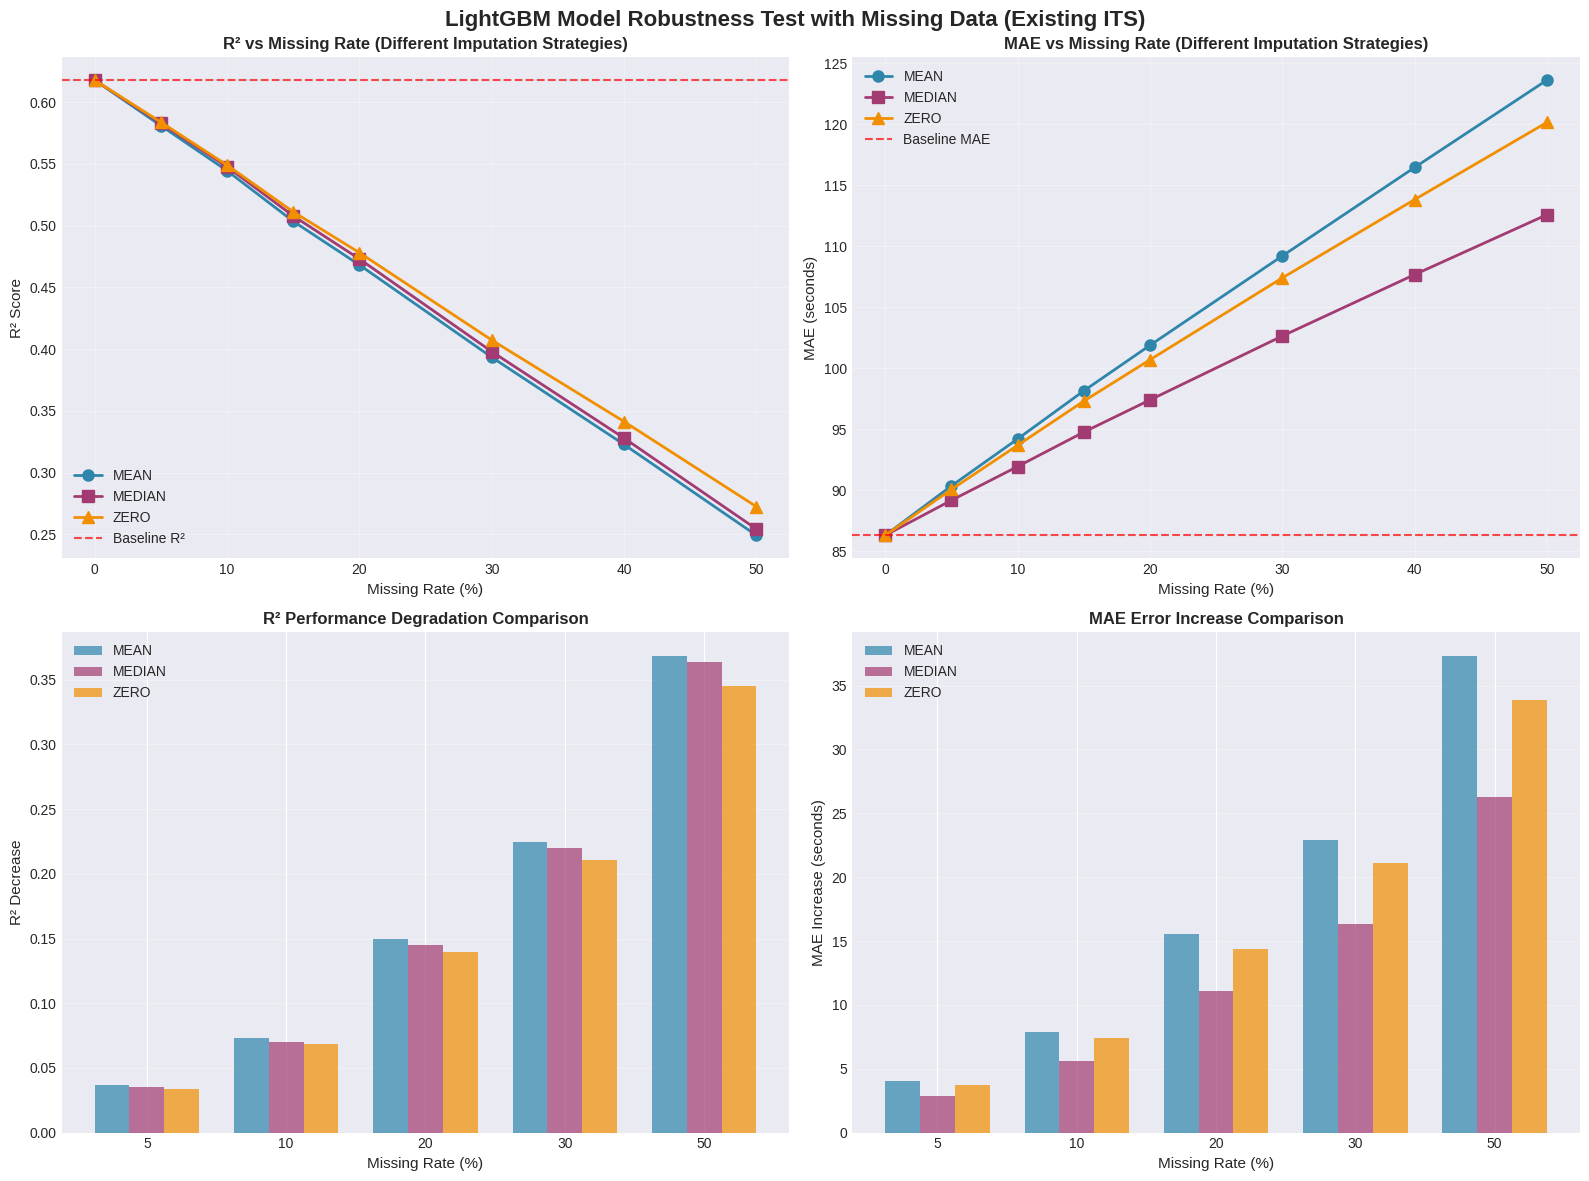


20% 缺失率下:
   最佳填充策略: ZERO
   R² 保留率: 77.4%
   R² 下降: 0.1397

填充策略性能排名 (20% 缺失率):
   ZERO    : R² = 0.4782, MAE = 100.68s
   MEDIAN  : R² = 0.4731, MAE = 97.39s
   MEAN    : R² = 0.4683, MAE = 101.87s

MEAN 策略最大可接受缺失率 (R² 保留率 > 80%):
   15%

MEDIAN 策略最大可接受缺失率 (R² 保留率 > 80%):
   15%

ZERO 策略最大可接受缺失率 (R² 保留率 > 80%):
   15%


In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


# 1. 准备测试数据
X_test_missing = X_test_existing_scaled.copy()
y_test_missing = y_test_existing

# 2. 定义缺失率
missing_rates = [0.0, 0.05, 0.10, 0.15, 0.20, 0.30, 0.40, 0.50]  # 0%, 5%, 10%, 15%, 20%, 30%, 40%, 50%

# 3. 定义缺失值填充策略
imputation_strategies = {
    'mean': lambda x: x.fillna(x.mean()),
    'median': lambda x: x.fillna(x.median()),
    'zero': lambda x: x.fillna(0)
}

# 4. 存储结果
results_lgb_existing_missing = {
    'missing_rate': [],
    'strategy': [],
    'r2': [],
    'mae': [],
    'rmse': [],
    'r2_drop': [],
    'mae_increase': []
}

# 5. 基准性能（无缺失）
best_lgb_model = lgb_model_existing
y_pred_baseline = best_lgb_model.predict(X_test_missing)
r2_baseline = r2_score(y_test_missing, y_pred_baseline)
mae_baseline = mean_absolute_error(y_test_missing, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test_missing, y_pred_baseline))

print(f"\n基准性能 (无缺失):")
print(f"  R² = {r2_baseline:.4f}")
print(f"  MAE = {mae_baseline:.2f}s")
print(f"  RMSE = {rmse_baseline:.2f}s")

# 6. 测试不同缺失率和填充策略
for missing_rate in missing_rates:
    print(f"[缺失率: {missing_rate*100:.0f}%]")

    if missing_rate == 0.0:
        # 无缺失情况
        for strategy_name in imputation_strategies.keys():
            results_lgb_existing_missing['missing_rate'].append(missing_rate * 100)
            results_lgb_existing_missing['strategy'].append(strategy_name)
            results_lgb_existing_missing['r2'].append(r2_baseline)
            results_lgb_existing_missing['mae'].append(mae_baseline)
            results_lgb_existing_missing['rmse'].append(rmse_baseline)
            results_lgb_existing_missing['r2_drop'].append(0.0)
            results_lgb_existing_missing['mae_increase'].append(0.0)
        print(f"  使用原始数据（无缺失）")
        continue

    # 创建缺失数据
    np.random.seed(42)  # 保证可重复性
    X_test_with_missing = X_test_missing.copy()

    # 随机选择要设为缺失的位置
    mask = np.random.random(X_test_with_missing.shape) < missing_rate
    X_test_with_missing = X_test_with_missing.mask(mask)

    actual_missing_rate = X_test_with_missing.isna().sum().sum() / X_test_with_missing.size
    print(f"  实际缺失率: {actual_missing_rate*100:.2f}%")
    print(f"  缺失值数量: {X_test_with_missing.isna().sum().sum()}")

    # 测试不同填充策略
    for strategy_name, impute_func in imputation_strategies.items():
        print(f"\n  填充策略: {strategy_name.upper()}")

        # 填充缺失值
        X_test_imputed = impute_func(X_test_with_missing.copy())

        # 预测
        y_pred_imputed = best_lgb_model.predict(X_test_imputed)

        # 转换为 numpy 数组
        if hasattr(y_test_missing, 'values'):
            y_test_array = y_test_missing.values
        else:
            y_test_array = y_test_missing

        # 计算指标
        r2_imputed = r2_score(y_test_array, y_pred_imputed)
        mae_imputed = mean_absolute_error(y_test_array, y_pred_imputed)
        rmse_imputed = np.sqrt(mean_squared_error(y_test_array, y_pred_imputed))

        # 计算下降/增加量
        r2_drop = r2_baseline - r2_imputed
        mae_increase = mae_imputed - mae_baseline

        # 存储结果
        results_lgb_existing_missing['missing_rate'].append(missing_rate * 100)
        results_lgb_existing_missing['strategy'].append(strategy_name)
        results_lgb_existing_missing['r2'].append(r2_imputed)
        results_lgb_existing_missing['mae'].append(mae_imputed)
        results_lgb_existing_missing['rmse'].append(rmse_imputed)
        results_lgb_existing_missing['r2_drop'].append(r2_drop)
        results_lgb_existing_missing['mae_increase'].append(mae_increase)

        # 打印结果
        print(f"     R² = {r2_imputed:.4f} (下降 {r2_drop:.4f}, {r2_drop/r2_baseline*100:.1f}%)")
        print(f"     MAE = {mae_imputed:.2f}s (增加 {mae_increase:.2f}s, {mae_increase/mae_baseline*100:.1f}%)")
        print(f"     RMSE = {rmse_imputed:.2f}s")

# 7. 转换为 DataFrame
df_results_xgb_existing_missing = pd.DataFrame(results_lgb_existing_missing)



# 8. 显示汇总表格
print("\n结果汇总表:")
print(df_results_xgb_existing_missing.to_string(index=False))

# 9. 可视化结果
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('LightGBM Model Robustness Test with Missing Data (Existing ITS)', fontsize=16, fontweight='bold')

colors = {'mean': '#2E86AB', 'median': '#A23B72', 'zero': '#F18F01'}
markers = {'mean': 'o', 'median': 's', 'zero': '^'}

# 子图1: R² vs 缺失率
for strategy in imputation_strategies.keys():
    data = df_results_xgb_existing_missing[df_results_xgb_existing_missing['strategy'] == strategy]
    axes[0, 0].plot(data['missing_rate'], data['r2'],
                    marker=markers[strategy], linewidth=2, markersize=8,
                    color=colors[strategy], label=strategy.upper())
axes[0, 0].axhline(y=r2_baseline, color='red', linestyle='--', label='Baseline R²', alpha=0.7)
axes[0, 0].set_xlabel('Missing Rate (%)', fontsize=11)
axes[0, 0].set_ylabel('R² Score', fontsize=11)
axes[0, 0].set_title('R² vs Missing Rate (Different Imputation Strategies)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 子图2: MAE vs 缺失率
for strategy in imputation_strategies.keys():
    data = df_results_xgb_existing_missing[df_results_xgb_existing_missing['strategy'] == strategy]
    axes[0, 1].plot(data['missing_rate'], data['mae'],
                    marker=markers[strategy], linewidth=2, markersize=8,
                    color=colors[strategy], label=strategy.upper())
axes[0, 1].axhline(y=mae_baseline, color='red', linestyle='--', label='Baseline MAE', alpha=0.7)
axes[0, 1].set_xlabel('Missing Rate (%)', fontsize=11)
axes[0, 1].set_ylabel('MAE (seconds)', fontsize=11)
axes[0, 1].set_title('MAE vs Missing Rate (Different Imputation Strategies)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 子图3: R² 下降量对比
missing_rates_plot = [5, 10, 20, 30, 50]
x_pos = np.arange(len(missing_rates_plot))
width = 0.25

for i, strategy in enumerate(imputation_strategies.keys()):
    r2_drops = []
    for rate in missing_rates_plot:
        data = df_results_xgb_existing_missing[
            (df_results_xgb_existing_missing['missing_rate'] == rate) &
            (df_results_xgb_existing_missing['strategy'] == strategy)
        ]
        r2_drops.append(data['r2_drop'].values[0] if len(data) > 0 else 0)

    axes[1, 0].bar(x_pos + i*width, r2_drops, width,
                   label=strategy.upper(), color=colors[strategy], alpha=0.7)

axes[1, 0].set_xlabel('Missing Rate (%)', fontsize=11)
axes[1, 0].set_ylabel('R² Decrease', fontsize=11)
axes[1, 0].set_title('R² Performance Degradation Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x_pos + width)
axes[1, 0].set_xticklabels(missing_rates_plot)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 子图4: MAE 增加量对比
for i, strategy in enumerate(imputation_strategies.keys()):
    mae_increases = []
    for rate in missing_rates_plot:
        data = df_results_xgb_existing_missing[
            (df_results_xgb_existing_missing['missing_rate'] == rate) &
            (df_results_xgb_existing_missing['strategy'] == strategy)
        ]
        mae_increases.append(data['mae_increase'].values[0] if len(data) > 0 else 0)

    axes[1, 1].bar(x_pos + i*width, mae_increases, width,
                   label=strategy.upper(), color=colors[strategy], alpha=0.7)

axes[1, 1].set_xlabel('Missing Rate (%)', fontsize=11)
axes[1, 1].set_ylabel('MAE Increase (seconds)', fontsize=11)
axes[1, 1].set_title('MAE Error Increase Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos + width)
axes[1, 1].set_xticklabels(missing_rates_plot)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



# 找出 20% 缺失率时的最佳策略
data_20 = df_results_xgb_existing_missing[df_results_xgb_existing_missing['missing_rate'] == 20.0]
best_strategy_20 = data_20.loc[data_20['r2'].idxmax(), 'strategy']
best_r2_20 = data_20['r2'].max()
r2_retention_20 = (best_r2_20 / r2_baseline) * 100

print(f"\n20% 缺失率下:")
print(f"   最佳填充策略: {best_strategy_20.upper()}")
print(f"   R² 保留率: {r2_retention_20:.1f}%")
print(f"   R² 下降: {r2_baseline - best_r2_20:.4f}")

# 比较不同策略
print(f"\n填充策略性能排名 (20% 缺失率):")
data_20_sorted = data_20.sort_values('r2', ascending=False)
for idx, row in data_20_sorted.iterrows():
    print(f"   {row['strategy'].upper():8s}: R² = {row['r2']:.4f}, MAE = {row['mae']:.2f}s")

# 找出最大可接受缺失率（R² 保留率 > 80%）
for strategy in imputation_strategies.keys():
    strategy_data = df_results_xgb_existing_missing[df_results_xgb_existing_missing['strategy'] == strategy]
    acceptable = strategy_data[strategy_data['r2'] / r2_baseline > 0.8]['missing_rate'].max()
    print(f"\n{strategy.upper()} 策略最大可接受缺失率 (R² 保留率 > 80%):")
    print(f"   {acceptable:.0f}%")



## 缺失，ad ITS


基准性能 (无缺失):
  R² = 0.9894
  MAE = 12.58s
  RMSE = 19.93s
[缺失率: 0%]
  使用原始数据（无缺失）
[缺失率: 5%]
  实际缺失率: 4.99%
  缺失值数量: 119740

填充策略: MEAN
     R² = 0.9331 (下降 0.0562, 5.7%)
     MAE = 20.83s (增加 8.25s, 65.5%)
     RMSE = 50.01s

填充策略: MEDIAN
     R² = 0.9297 (下降 0.0597, 6.0%)
     MAE = 20.44s (增加 7.86s, 62.5%)
     RMSE = 51.29s

填充策略: ZERO
     R² = 0.9331 (下降 0.0563, 5.7%)
     MAE = 20.84s (增加 8.25s, 65.6%)
     RMSE = 50.01s
[缺失率: 10%]
  实际缺失率: 10.00%
  缺失值数量: 239748

填充策略: MEAN
     R² = 0.8859 (下降 0.1034, 10.5%)
     MAE = 28.50s (增加 15.92s, 126.5%)
     RMSE = 65.31s

填充策略: MEDIAN
     R² = 0.8790 (下降 0.1104, 11.2%)
     MAE = 27.77s (增加 15.18s, 120.7%)
     RMSE = 67.27s

填充策略: ZERO
     R² = 0.8859 (下降 0.1034, 10.5%)
     MAE = 28.51s (增加 15.93s, 126.6%)
     RMSE = 65.31s
[缺失率: 15%]
  实际缺失率: 14.98%
  缺失值数量: 359195

填充策略: MEAN
     R² = 0.8335 (下降 0.1559, 15.8%)
     MAE = 36.10s (增加 23.51s, 186.8%)
     RMSE = 78.90s

填充策略: MEDIAN
     R² = 0.8227 (下降 0.1667, 16.8%)
     MAE = 

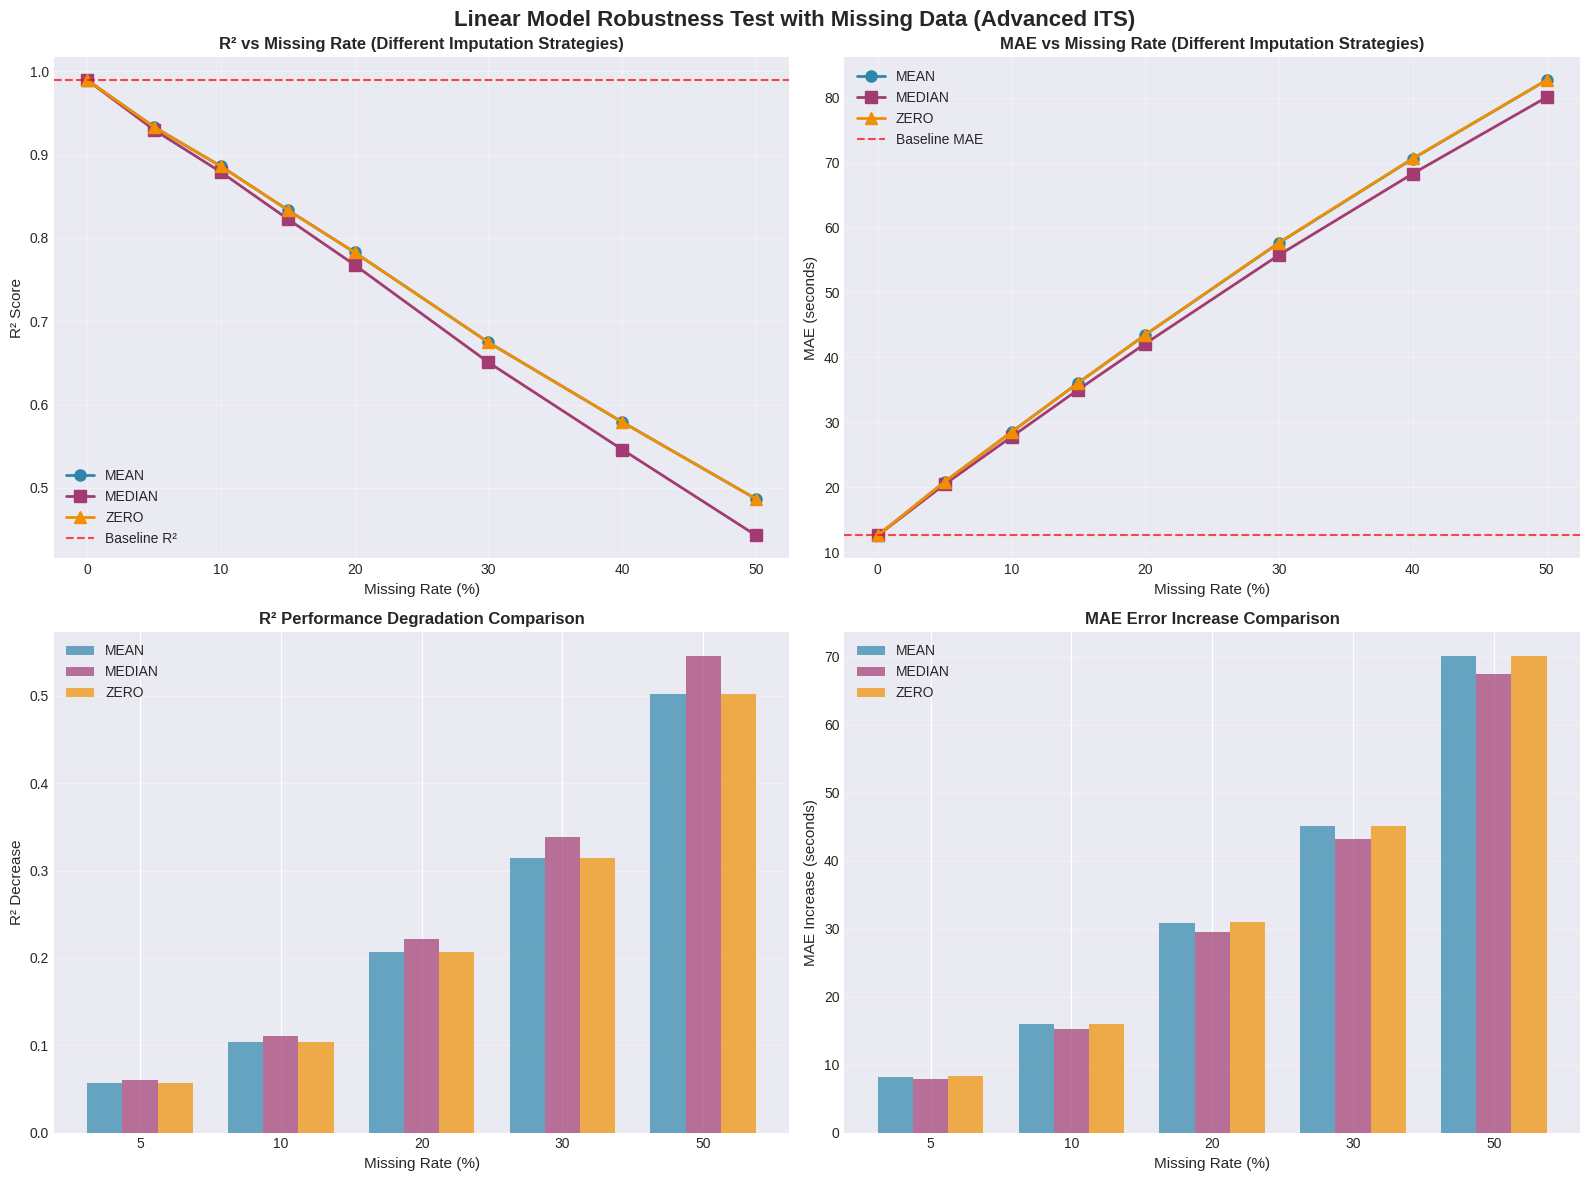


20% 缺失率下:
   最佳填充策略: MEAN
   R² 保留率: 79.1%
   R² 下降: 0.2067

填充策略性能排名 (20% 缺失率):
   MEAN    : R² = 0.7826, MAE = 43.48s
   ZERO    : R² = 0.7826, MAE = 43.49s
   MEDIAN  : R² = 0.7676, MAE = 42.12s

MEAN 策略最大可接受缺失率 (R² 保留率 > 80%):
   15%

MEDIAN 策略最大可接受缺失率 (R² 保留率 > 80%):
   15%

ZERO 策略最大可接受缺失率 (R² 保留率 > 80%):
   15%


In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 1. 准备测试数据
X_test_missing = X_test_advanced_scaled.copy()
y_test_missing = y_test_advanced

# 2. 定义缺失率
missing_rates = [0.0, 0.05, 0.10, 0.15, 0.20, 0.30, 0.40, 0.50]  # 0%, 5%, 10%, 15%, 20%, 30%, 40%, 50%

# 3. 定义缺失值填充策略
imputation_strategies = {
    'mean': lambda x: x.fillna(x.mean()),
    'median': lambda x: x.fillna(x.median()),
    'zero': lambda x: x.fillna(0)
}

# 4. 存储结果
results_lr_advanced_missing = {
    'missing_rate': [],
    'strategy': [],
    'r2': [],
    'mae': [],
    'rmse': [],
    'r2_drop': [],
    'mae_increase': []
}

# 5. 基准性能（无缺失）
best_linear_model = lr_model_advanced
y_pred_baseline = best_linear_model.predict(X_test_missing)
r2_baseline = r2_score(y_test_missing, y_pred_baseline)
mae_baseline = mean_absolute_error(y_test_missing, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test_missing, y_pred_baseline))

print(f"\n基准性能 (无缺失):")
print(f"  R² = {r2_baseline:.4f}")
print(f"  MAE = {mae_baseline:.2f}s")
print(f"  RMSE = {rmse_baseline:.2f}s")

# 6. 测试不同缺失率和填充策略
for missing_rate in missing_rates:
    print(f"[缺失率: {missing_rate*100:.0f}%]")

    if missing_rate == 0.0:
        # 无缺失情况
        for strategy_name in imputation_strategies.keys():
            results_lr_advanced_missing['missing_rate'].append(missing_rate * 100)
            results_lr_advanced_missing['strategy'].append(strategy_name)
            results_lr_advanced_missing['r2'].append(r2_baseline)
            results_lr_advanced_missing['mae'].append(mae_baseline)
            results_lr_advanced_missing['rmse'].append(rmse_baseline)
            results_lr_advanced_missing['r2_drop'].append(0.0)
            results_lr_advanced_missing['mae_increase'].append(0.0)
        print(f"  使用原始数据（无缺失）")
        continue

    # 创建缺失数据
    np.random.seed(42)  # 保证可重复性
    X_test_with_missing = X_test_missing.copy()

    # 随机选择要设为缺失的位置
    mask = np.random.random(X_test_with_missing.shape) < missing_rate
    X_test_with_missing = X_test_with_missing.mask(mask)

    actual_missing_rate = X_test_with_missing.isna().sum().sum() / X_test_with_missing.size
    print(f"  实际缺失率: {actual_missing_rate*100:.2f}%")
    print(f"  缺失值数量: {X_test_with_missing.isna().sum().sum()}")

    # 测试不同填充策略
    for strategy_name, impute_func in imputation_strategies.items():
        print(f"\n填充策略: {strategy_name.upper()}")

        # 填充缺失值
        X_test_imputed = impute_func(X_test_with_missing.copy())

        # 预测
        y_pred_imputed = best_linear_model.predict(X_test_imputed)

        # 转换为 numpy 数组
        if hasattr(y_test_missing, 'values'):
            y_test_array = y_test_missing.values
        else:
            y_test_array = y_test_missing

        # 计算指标
        r2_imputed = r2_score(y_test_array, y_pred_imputed)
        mae_imputed = mean_absolute_error(y_test_array, y_pred_imputed)
        rmse_imputed = np.sqrt(mean_squared_error(y_test_array, y_pred_imputed))

        # 计算下降/增加量
        r2_drop = r2_baseline - r2_imputed
        mae_increase = mae_imputed - mae_baseline

        # 存储结果
        results_lr_advanced_missing['missing_rate'].append(missing_rate * 100)
        results_lr_advanced_missing['strategy'].append(strategy_name)
        results_lr_advanced_missing['r2'].append(r2_imputed)
        results_lr_advanced_missing['mae'].append(mae_imputed)
        results_lr_advanced_missing['rmse'].append(rmse_imputed)
        results_lr_advanced_missing['r2_drop'].append(r2_drop)
        results_lr_advanced_missing['mae_increase'].append(mae_increase)

        # 打印结果
        print(f"     R² = {r2_imputed:.4f} (下降 {r2_drop:.4f}, {r2_drop/r2_baseline*100:.1f}%)")
        print(f"     MAE = {mae_imputed:.2f}s (增加 {mae_increase:.2f}s, {mae_increase/mae_baseline*100:.1f}%)")
        print(f"     RMSE = {rmse_imputed:.2f}s")

# 7. 转换为 DataFrame
df_results_lr_advanced_missing = pd.DataFrame(results_lr_advanced_missing)


print(df_results_lr_advanced_missing.to_string(index=False))

# 9. 可视化结果
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Linear Model Robustness Test with Missing Data (Advanced ITS)', fontsize=16, fontweight='bold')

colors = {'mean': '#2E86AB', 'median': '#A23B72', 'zero': '#F18F01'}
markers = {'mean': 'o', 'median': 's', 'zero': '^'}


# 子图1: R² vs 缺失率
for strategy in imputation_strategies.keys():
    data = df_results_lr_advanced_missing[df_results_lr_advanced_missing['strategy'] == strategy]
    axes[0, 0].plot(data['missing_rate'], data['r2'],
                    marker=markers[strategy], linewidth=2, markersize=8,
                    color=colors[strategy], label=strategy.upper())
axes[0, 0].axhline(y=r2_baseline, color='red', linestyle='--', label='Baseline R²', alpha=0.7)
axes[0, 0].set_xlabel('Missing Rate (%)', fontsize=11)
axes[0, 0].set_ylabel('R² Score', fontsize=11)
axes[0, 0].set_title('R² vs Missing Rate (Different Imputation Strategies)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 子图2: MAE vs 缺失率
for strategy in imputation_strategies.keys():
    data = df_results_lr_advanced_missing[df_results_lr_advanced_missing['strategy'] == strategy]
    axes[0, 1].plot(data['missing_rate'], data['mae'],
                    marker=markers[strategy], linewidth=2, markersize=8,
                    color=colors[strategy], label=strategy.upper())
axes[0, 1].axhline(y=mae_baseline, color='red', linestyle='--', label='Baseline MAE', alpha=0.7)
axes[0, 1].set_xlabel('Missing Rate (%)', fontsize=11)
axes[0, 1].set_ylabel('MAE (seconds)', fontsize=11)
axes[0, 1].set_title('MAE vs Missing Rate (Different Imputation Strategies)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 子图3: R² 下降量对比
missing_rates_plot = [5, 10, 20, 30, 50]
x_pos = np.arange(len(missing_rates_plot))
width = 0.25

for i, strategy in enumerate(imputation_strategies.keys()):
    r2_drops = []
    for rate in missing_rates_plot:
        data = df_results_lr_advanced_missing[
            (df_results_lr_advanced_missing['missing_rate'] == rate) &
            (df_results_lr_advanced_missing['strategy'] == strategy)
        ]
        r2_drops.append(data['r2_drop'].values[0] if len(data) > 0 else 0)

    axes[1, 0].bar(x_pos + i*width, r2_drops, width,
                   label=strategy.upper(), color=colors[strategy], alpha=0.7)

axes[1, 0].set_xlabel('Missing Rate (%)', fontsize=11)
axes[1, 0].set_ylabel('R² Decrease', fontsize=11)
axes[1, 0].set_title('R² Performance Degradation Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x_pos + width)
axes[1, 0].set_xticklabels(missing_rates_plot)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 子图4: MAE 增加量对比
for i, strategy in enumerate(imputation_strategies.keys()):
    mae_increases = []
    for rate in missing_rates_plot:
        data = df_results_lr_advanced_missing[
            (df_results_lr_advanced_missing['missing_rate'] == rate) &
            (df_results_lr_advanced_missing['strategy'] == strategy)
        ]
        mae_increases.append(data['mae_increase'].values[0] if len(data) > 0 else 0)

    axes[1, 1].bar(x_pos + i*width, mae_increases, width,
                   label=strategy.upper(), color=colors[strategy], alpha=0.7)

axes[1, 1].set_xlabel('Missing Rate (%)', fontsize=11)
axes[1, 1].set_ylabel('MAE Increase (seconds)', fontsize=11)
axes[1, 1].set_title('MAE Error Increase Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos + width)
axes[1, 1].set_xticklabels(missing_rates_plot)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


# 找出 20% 缺失率时的最佳策略
data_20 = df_results_lr_advanced_missing[df_results_lr_advanced_missing['missing_rate'] == 20.0]
best_strategy_20 = data_20.loc[data_20['r2'].idxmax(), 'strategy']
best_r2_20 = data_20['r2'].max()
r2_retention_20 = (best_r2_20 / r2_baseline) * 100

print(f"\n20% 缺失率下:")
print(f"   最佳填充策略: {best_strategy_20.upper()}")
print(f"   R² 保留率: {r2_retention_20:.1f}%")
print(f"   R² 下降: {r2_baseline - best_r2_20:.4f}")

# 比较不同策略
print(f"\n填充策略性能排名 (20% 缺失率):")
data_20_sorted = data_20.sort_values('r2', ascending=False)
for idx, row in data_20_sorted.iterrows():
    print(f"   {row['strategy'].upper():8s}: R² = {row['r2']:.4f}, MAE = {row['mae']:.2f}s")

# 找出最大可接受缺失率（R² 保留率 > 80%）
for strategy in imputation_strategies.keys():
    strategy_data = df_results_lr_advanced_missing[df_results_lr_advanced_missing['strategy'] == strategy]
    acceptable = strategy_data[strategy_data['r2'] / r2_baseline > 0.8]['missing_rate'].max()
    print(f"\n{strategy.upper()} 策略最大可接受缺失率 (R² 保留率 > 80%):")
    print(f"   {acceptable:.0f}%")

